# Data analysis

In [1]:
import json
import sys
import networkx
import pandas
import numpy

import matplotlib.pyplot as plotter
from pathlib import Path

Data dir containing all files

In [2]:
!ls -la /home/ashinde/PhD/CaffineBravery/

total 48
drwxr-xr-x 20 ashinde ashinde 4096 Feb  2 17:23 .
drwxrwxr-x  6 ashinde ashinde   84 Dec  7 19:05 ..
drwxr-xr-x  7 ashinde ashinde  124 Nov 15 11:34 app
drwxr-xr-x  4 ashinde ashinde  142 Oct 15 15:33 domains
drwxr-xr-x  8 ashinde ashinde  220 Feb 14 12:17 .git
-rw-r--r--  1 ashinde ashinde  154 May 24  2022 .gitattributes
-rw-r--r--  1 ashinde ashinde  129 May 24  2022 .gitignore
drwxrwxr-x  6 ashinde ashinde   73 Jun  7  2022 .gradle
drwxr-xr-x  3 ashinde ashinde   21 May 24  2022 gradle
-rwxr-xr-x  1 ashinde ashinde 5774 May 24  2022 gradlew
-rw-r--r--  1 ashinde ashinde 2763 May 24  2022 gradlew.bat
drwxrwxr-x  2 ashinde ashinde   52 Jul 19  2022 policies
-rw-rw-r--  1 ashinde ashinde  743 Jun  7  2022 .project
drwxrwxr-x  2 ashinde ashinde   62 Nov 29 12:57 results
drwxrwxr-x  2 ashinde ashinde  101 Feb  1 18:21 results_l1_active
drwxrwxr-x  2 ashinde ashinde   63 Feb  2 14:29 results_l1_active_control
drwxrwxr-x  2 ashinde ashinde  100 Nov 29 21:44 results_l1_active_crit

In [3]:
# Data files
data_dir = Path("/home/ashinde/PhD/CaffineBravery/results_l2_control/")
data_files = list(data_dir.iterdir())

graph_files = list(filter(lambda x: "pol_graph" in str(x), data_files))
print(f"Policy graph files: {graph_files}")

trace_file = list(filter(lambda x: "trace" in str(x), data_files))[0]
print(f"Trace file: {trace_file}")

Policy graph files: [PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2_control/2043106095_attl0_pol_graph.json'), PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2_control/758572926_attl0_pol_graph.json'), PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2_control/1454026445_defl1_active_pol_graph.json'), PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2_control/172794870_defl1_passive_pol_graph.json'), PosixPath('/home/ashinde/PhD/CaffineBravery/results_l2_control/893640573_attl2_pol_graph.json')]
Trace file: /home/ashinde/PhD/CaffineBravery/results_l2_control/trace.json


In [4]:
def load_json(fname):

    data = None

    with open(fname) as f:
        data = json.load(f)

    return data

In [5]:
# Draw policy graphs
def to_networkx_graph(json_data):

    nodes = json_data["nodes"]
    edges = json_data["edges"]

    G = networkx.MultiDiGraph()
    labels = {}
    edge_labels = {}
    edge_print = {}

    for k, v in nodes.items():
        
        if "start" in v.keys():
            labels[k] = f"start_{v['act']}"
        else:
            labels[k] = v["act"]
        G.add_node(k)
        
    for n, e in edges.items():
        for l, _n in e.items():
            G.add_edge(n, _n, label=l)
            
            e_data = G.get_edge_data(n, _n)
            label = [l["label"] for l in e_data.values()]
            # print(label)
            edge_labels[(n, _n)] = list(e_data.keys())

    # pos = networkx.shell_layout(G, scale=1)
    # networkx.draw_networkx_labels(G, pos, labels)
    
    print(G)
    pos = networkx.nx_pydot.graphviz_layout(G, prog="neato")
    networkx.draw(G, pos, labels=labels, with_labels=True, font_size=8, alpha=0.5, width=0.2)
    plotter.show()

---
## Plot policy graphs

/home/ashinde/PhD/CaffineBravery/results_l2_control/2043106095_attl0_pol_graph.json
MultiDiGraph with 12 nodes and 76 edges


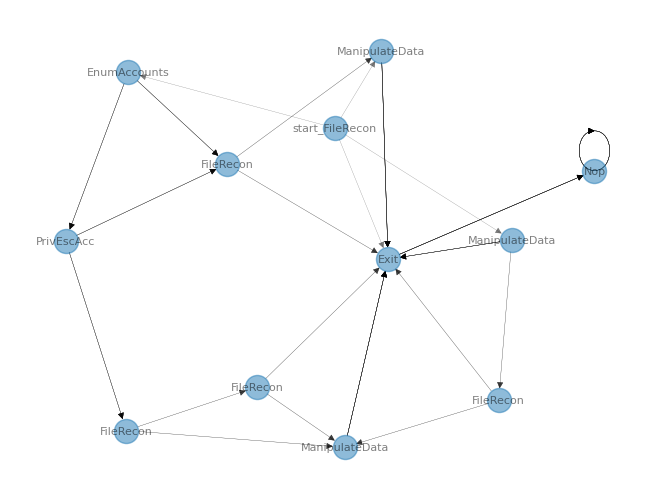

/home/ashinde/PhD/CaffineBravery/results_l2_control/758572926_attl0_pol_graph.json
MultiDiGraph with 18 nodes and 112 edges


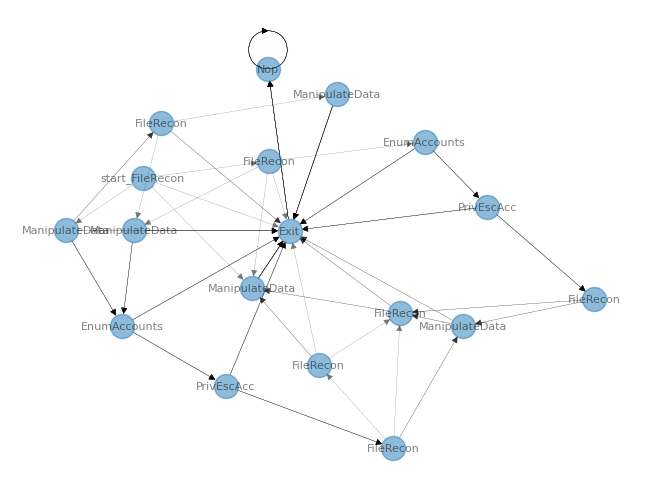

/home/ashinde/PhD/CaffineBravery/results_l2_control/1454026445_defl1_active_pol_graph.json
MultiDiGraph with 5 nodes and 20 edges


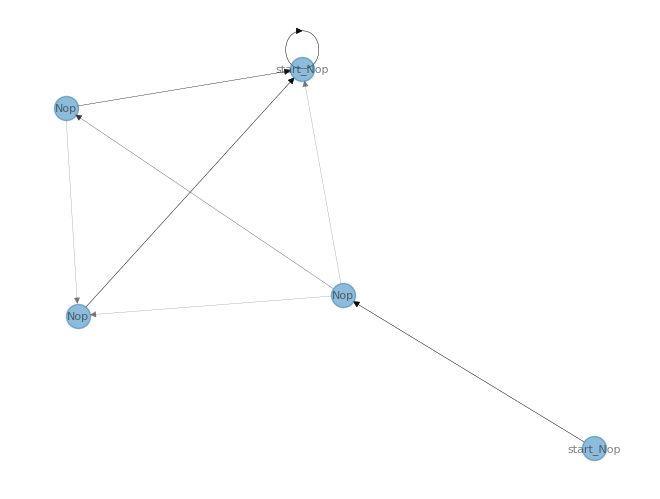

/home/ashinde/PhD/CaffineBravery/results_l2_control/172794870_defl1_passive_pol_graph.json
MultiDiGraph with 32 nodes and 128 edges


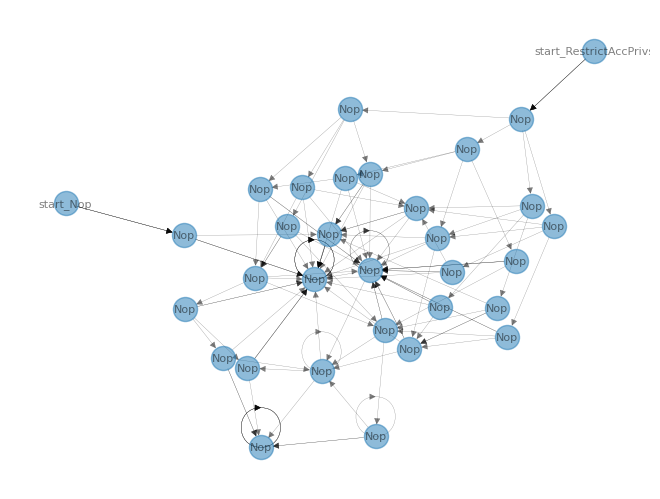

/home/ashinde/PhD/CaffineBravery/results_l2_control/893640573_attl2_pol_graph.json
MultiDiGraph with 2 nodes and 16 edges


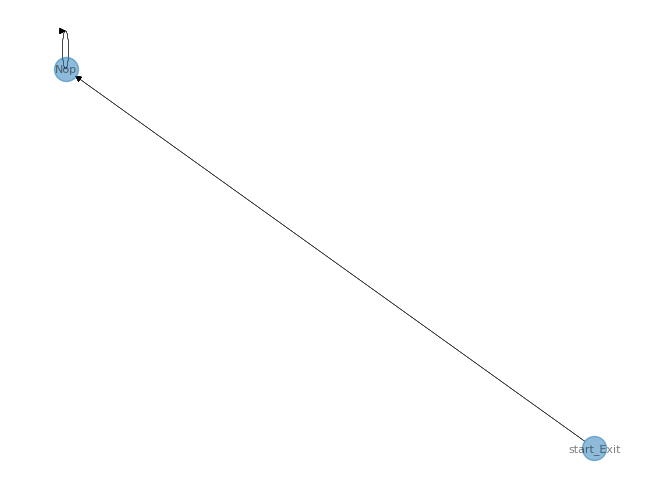

In [6]:
for g in graph_files:
    print(g)
    data = load_json(g)
    to_networkx_graph(data)

---
## Beliefs 

In [7]:
import summarize_interaction

# load json data
data = load_json(trace_file)

keys, b_traces = summarize_interaction.get_all_belief_traces(data)

print("Plotting belief divergence over")
for k in keys:
    print(k)

Plotting belief divergence over
('HostType', ['critical', 'critical_honeypot', 'honeypot'])
('HostHasData', ['no', 'yes'])
('DataPrivs', ['root', 'user'])
('EscAccounts', ['no', 'yes'])
('AccFound', ['no', 'yes'])
('DataFound', ['no', 'yes'])
('AccessLevel', ['root', 'user'])
('AttActive', ['no', 'yes'])
('DataInjected', ['no', 'yes'])


Plotting for ('HostType', ['critical', 'critical_honeypot', 'honeypot'])


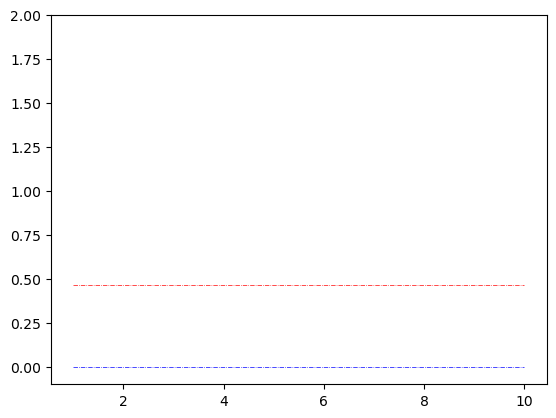

Plotting for ('HostHasData', ['no', 'yes'])


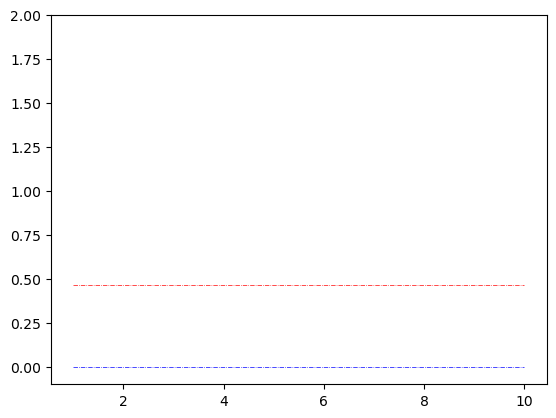

Plotting for ('DataPrivs', ['root', 'user'])


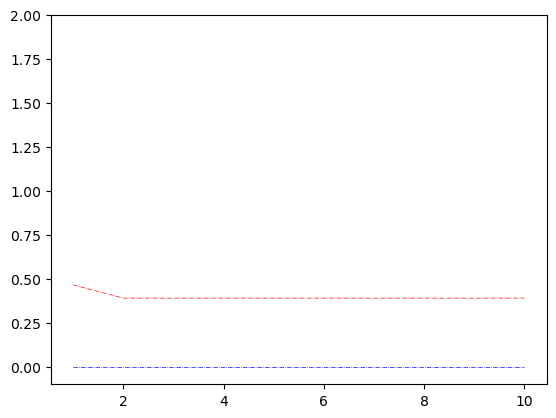

Plotting for ('EscAccounts', ['no', 'yes'])


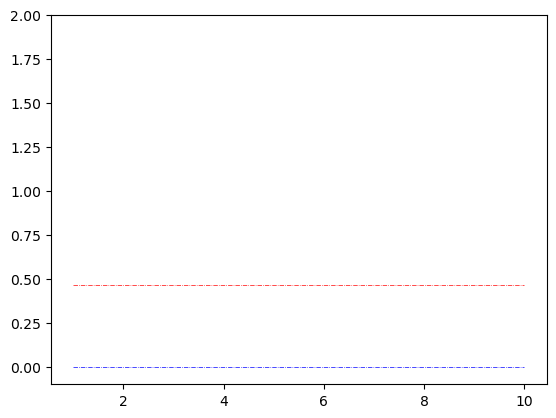

Plotting for ('AccFound', ['no', 'yes'])


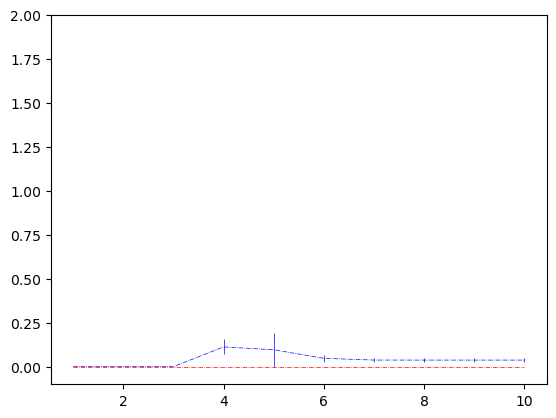

Plotting for ('DataFound', ['no', 'yes'])


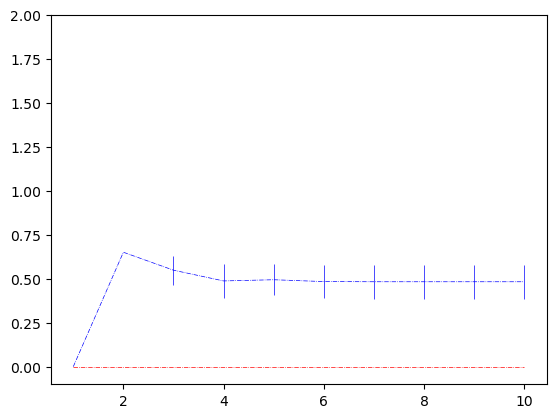

Plotting for ('AccessLevel', ['root', 'user'])


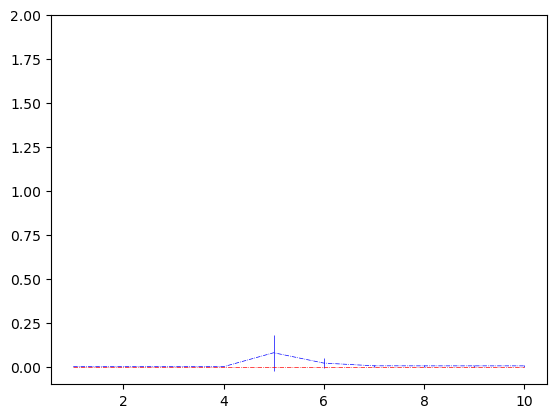

Plotting for ('AttActive', ['no', 'yes'])


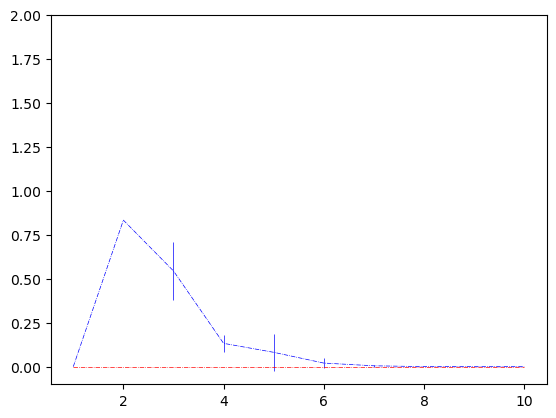

Plotting for ('DataInjected', ['no', 'yes'])


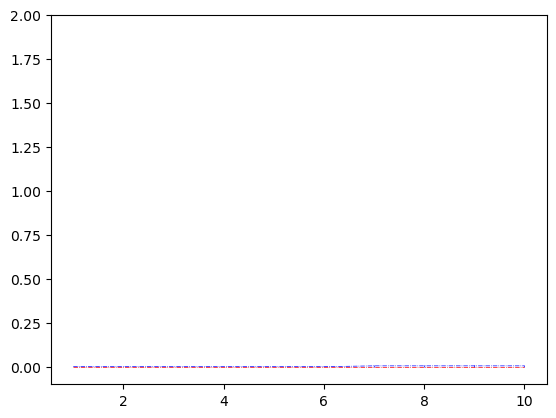

In [8]:
# Get divergence
divs = []
for b_trace in b_traces:
    divs.append(summarize_interaction.get_divergence(b_trace))
    
for i in range(len(keys)):
    print(f"Plotting for {keys[i]}")
    
    i_means = numpy.mean(divs[i][0], axis=0)
    i_dev = numpy.std(divs[i][0], axis=0)
    plotter.errorbar(numpy.linspace(1, i_means.shape[0], i_means.shape[0]), i_means, fmt='r-.', yerr=i_dev, linewidth=0.5)
    
    if len(divs[i]) > 1:
        j_means = numpy.mean(divs[i][1], axis=0)
        j_dev = numpy.std(divs[i][1], axis=0)
        plotter.errorbar(numpy.linspace(1, j_means.shape[0], j_means.shape[0]), j_means, fmt='b-.', yerr=j_dev, linewidth=0.5)
        # plotter.plot(divs[i][1].T, 'b-.', linewidth=0.5)
    
    plotter.ylim(-0.1, 2)
    plotter.show()
    

---
# Display interaction examples

,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,Exit,auth|none|success|terminated|none,RestrictAccPrivs,none
1,Nop,auth|user_files|success|terminated|none,Nop,none
2,Nop,auth|none|failure|terminated|none,Nop,none
3,Nop,denied|none|failure|terminated|none,Nop,none
4,Nop,auth|user_files|failure|terminated|none,Nop,none
5,Nop,auth|user_files|success|terminated|none,Nop,none
6,Nop,denied|none|failure|terminated|none,Nop,none
7,Nop,auth|none|success|terminated|none,Nop,none
8,Nop,denied|none|failure|terminated|none,Nop,none
9,Nop,denied|user_files|success|terminated|none,Nop,none


Agent i's P(Aj)


,DecoyAccount,DeployData,LockAccounts,Nop,RestrictAccPrivs
0,0.0,0.0,0.0,0.75,0.25
1,0.0,0.0,0.0,1.00,0.00
2,0.0,0.0,0.0,1.00,0.00
3,0.0,0.0,0.0,1.00,0.00
4,0.0,0.0,0.0,1.00,0.00
5,0.0,0.0,0.0,1.00,0.00
6,0.0,0.0,0.0,1.00,0.00
7,0.0,0.0,0.0,1.00,0.00
8,0.0,0.0,0.0,1.00,0.00
9,0.0,0.0,0.0,1.00,0.00


Agent j's P(Aj)


,EnumAccounts,Exit,FileRecon,ManipulateData,Nop,PrivEscAcc
0,0.000000,0.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000
1,0.000000,7.800001e-02,1.820000e-01,7.400000e-01,0.000000,0.000000
2,0.267482,1.146352e-01,0.000000e+00,2.802491e-02,0.589858,0.000000
3,0.001599,6.352148e-03,0.000000e+00,0.000000e+00,0.975920,0.016129
4,0.000000,5.094138e-05,9.388030e-04,0.000000e+00,0.998939,0.000071
5,0.000000,1.126116e-07,1.095512e-05,4.837513e-05,0.999941,0.000000
6,0.000000,2.872582e-06,5.979335e-08,5.578343e-07,0.999997,0.000000
7,0.000000,3.315410e-08,1.985095e-10,2.978455e-09,1.000000,0.000000
8,0.000000,1.773177e-10,0.000000e+00,9.562487e-12,1.000000,0.000000
9,0.000000,5.624992e-13,0.000000e+00,0.000000e+00,1.000000,0.000000


,highCap,lowCap
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


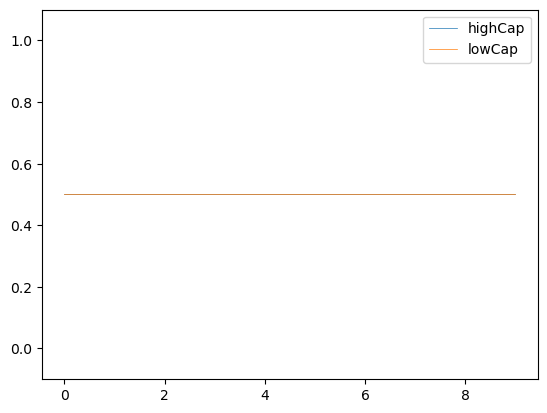

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


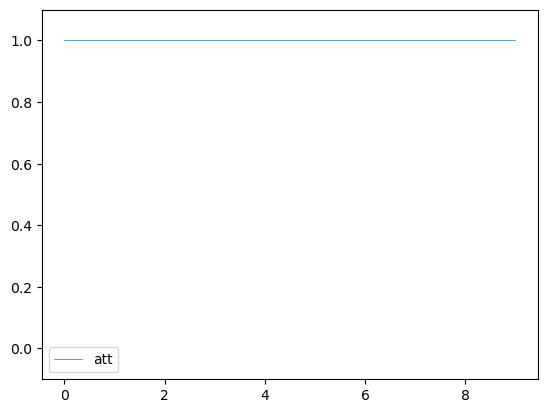

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


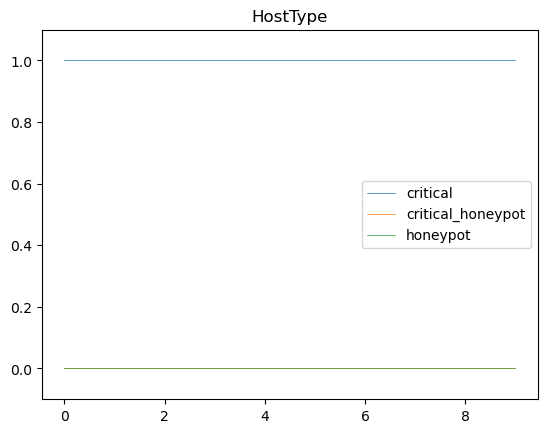

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.5,0.0,0.5
1,0.5,0.0,0.5
2,0.5,0.0,0.5
3,0.5,0.0,0.5
4,0.5,0.0,0.5
5,0.5,0.0,0.5
6,0.5,0.0,0.5
7,0.5,0.0,0.5
8,0.5,0.0,0.5
9,0.5,0.0,0.5


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


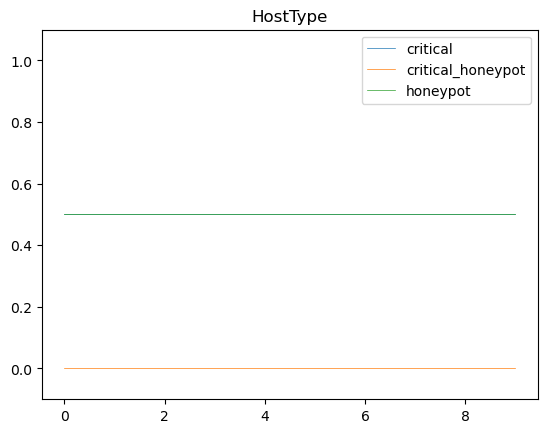

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


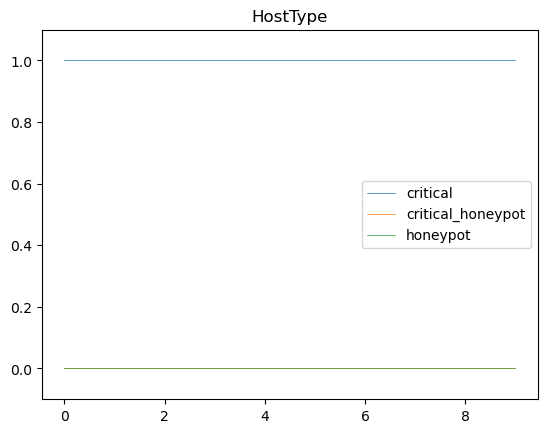

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for state:


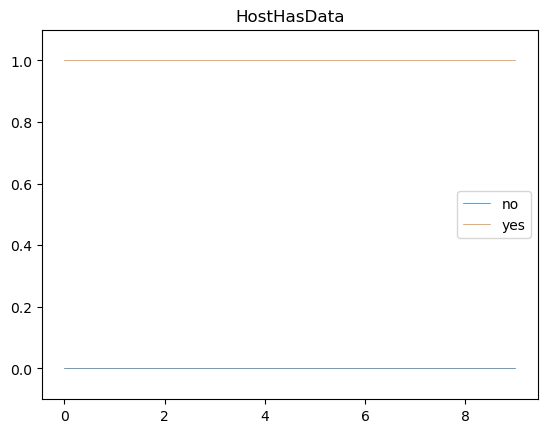

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('HostHasData', ['no', 'yes']) for agent_i


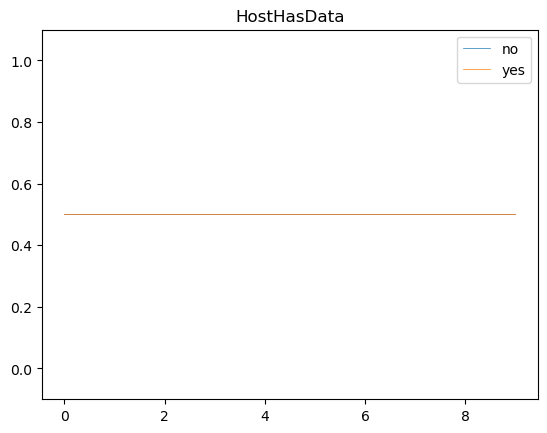

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


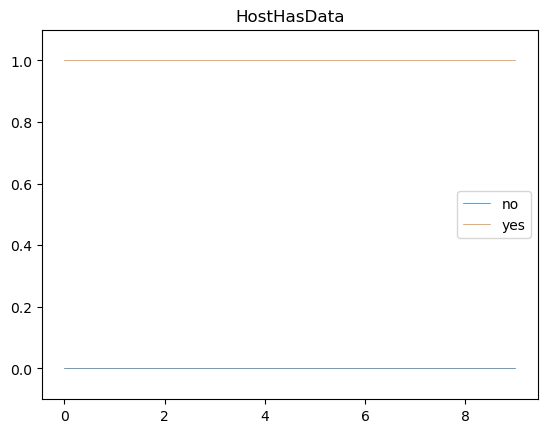

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


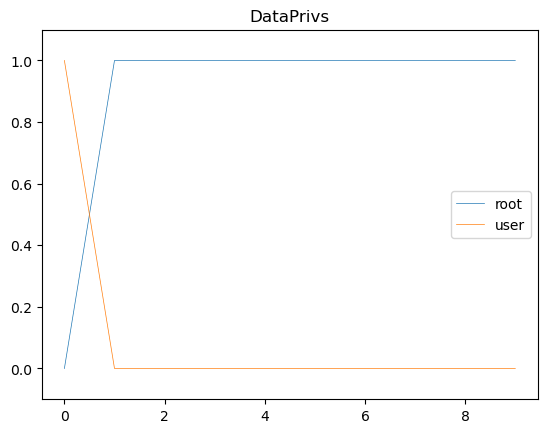

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.500,0.500
1,0.625,0.375
2,0.625,0.375
3,0.625,0.375
4,0.625,0.375
5,0.625,0.375
6,0.625,0.375
7,0.625,0.375
8,0.625,0.375
9,0.625,0.375


Plotting ('DataPrivs', ['root', 'user']) for agent_i


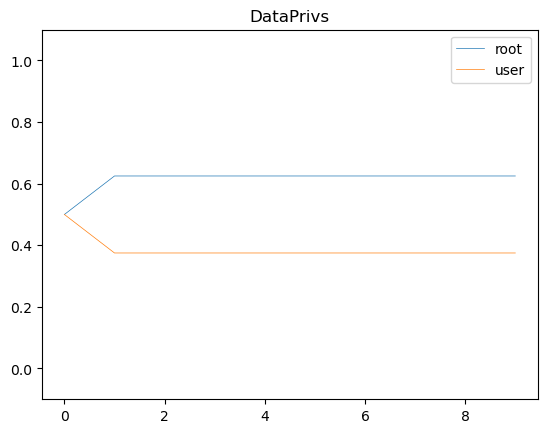

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


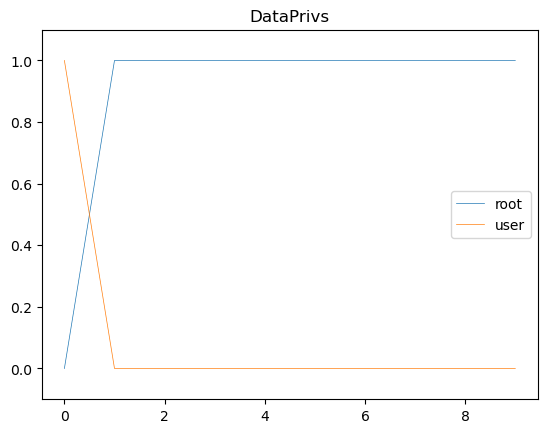

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


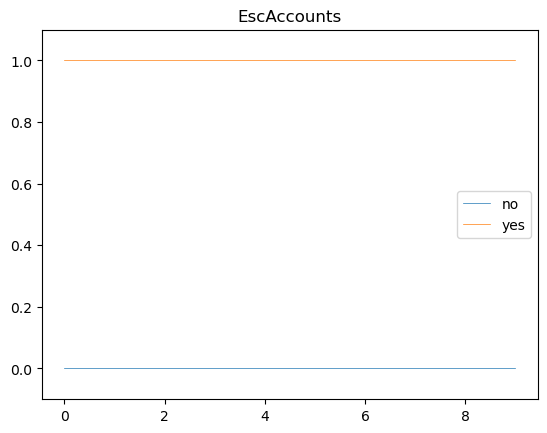

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


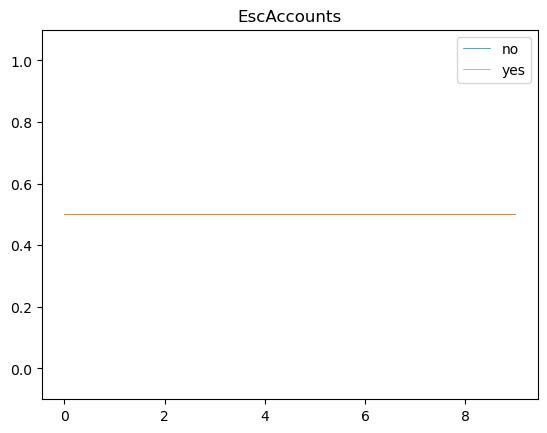

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


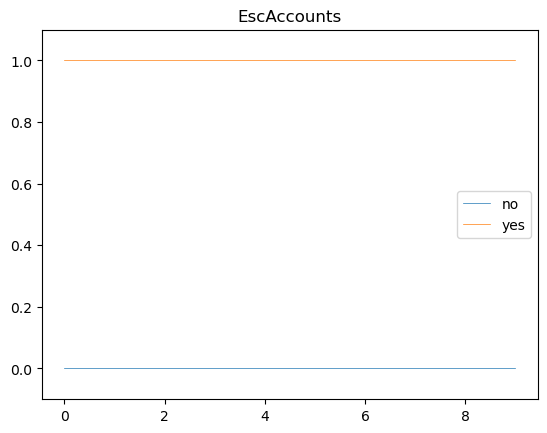

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for state:


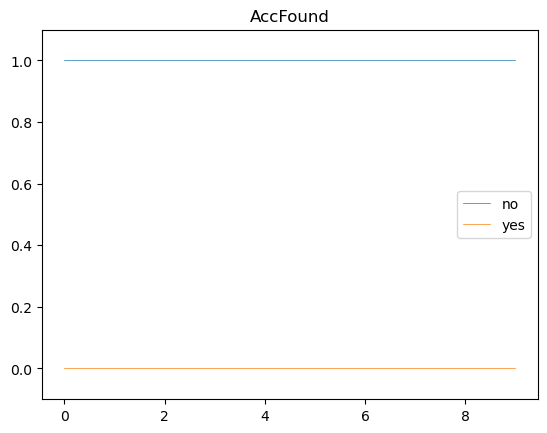

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for agent_i


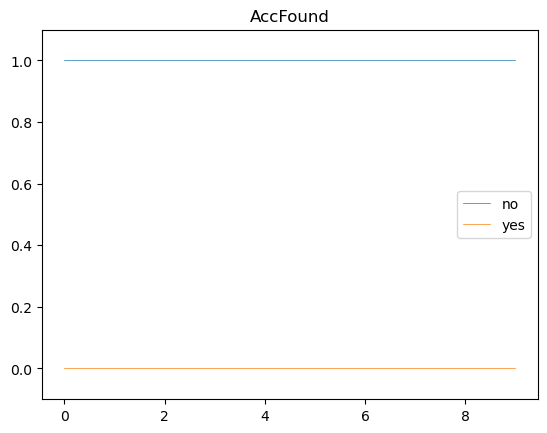

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,0.982563,0.017437
4,0.997211,0.002789
5,0.998158,0.001842
6,0.998214,0.001786
7,0.998214,0.001786
8,0.998214,0.001786
9,0.998214,0.001786


Plotting ('AccFound', ['no', 'yes']) for agent_j


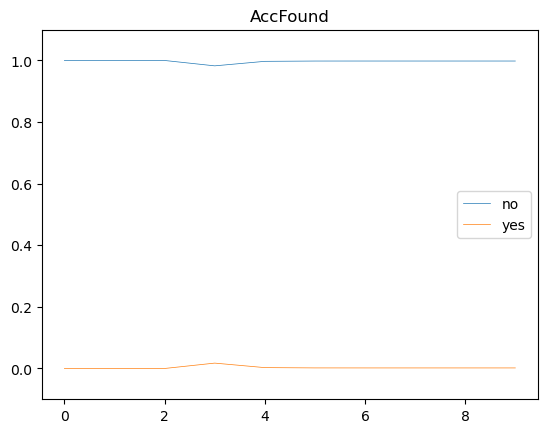

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for state:


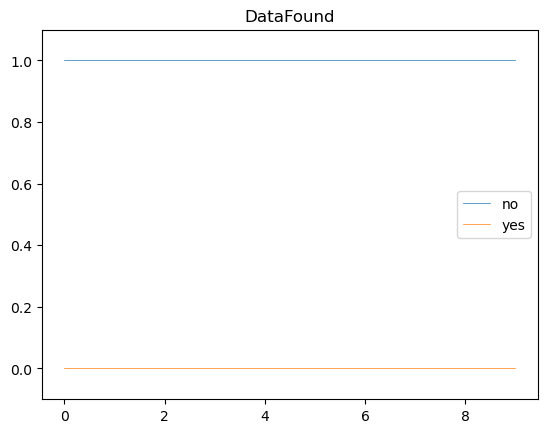

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for agent_i


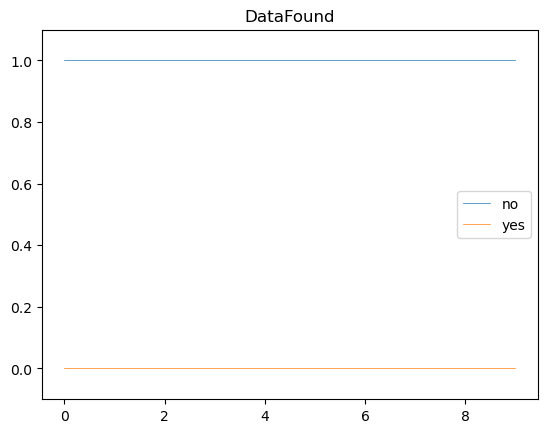

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,0.200000,0.800000
2,0.473310,0.526690
3,0.594200,0.405800
4,0.601579,0.398421
5,0.601994,0.398006
6,0.602025,0.397975
7,0.602025,0.397975
8,0.602025,0.397975
9,0.602025,0.397975


Plotting ('DataFound', ['no', 'yes']) for agent_j


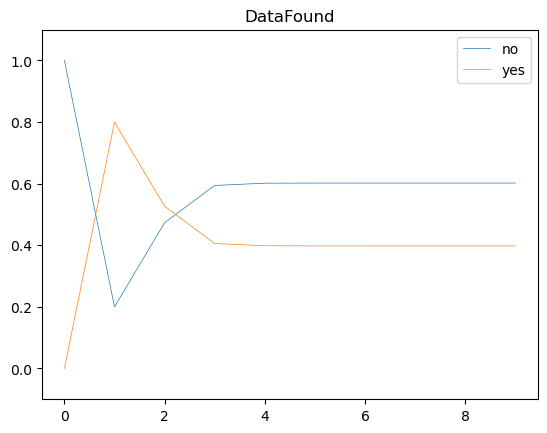

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for state:


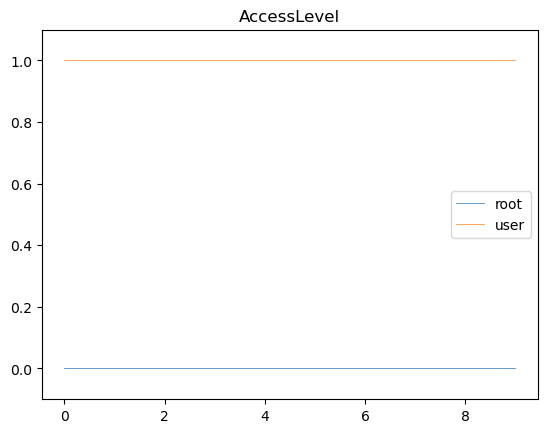

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


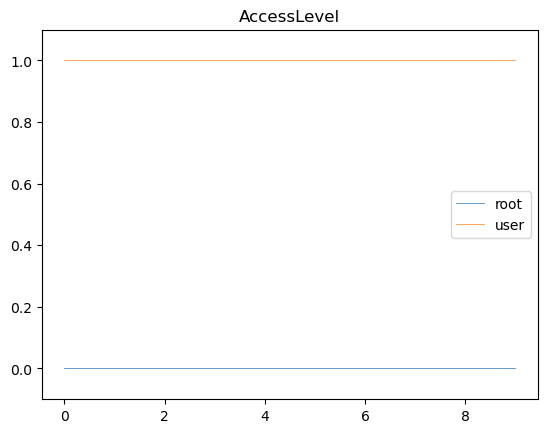

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.000939,0.999061
5,0.000059,0.999941
6,0.000003,0.999997
7,0.000003,0.999997
8,0.000003,0.999997
9,0.000003,0.999997


Plotting ('AccessLevel', ['root', 'user']) for agent_j


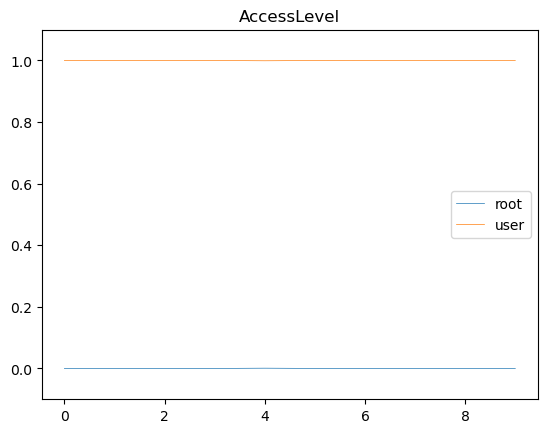

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


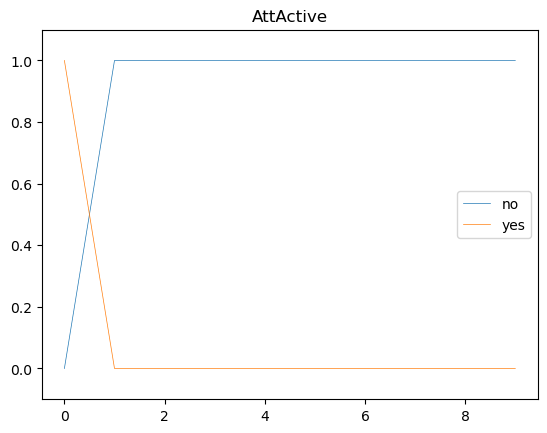

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


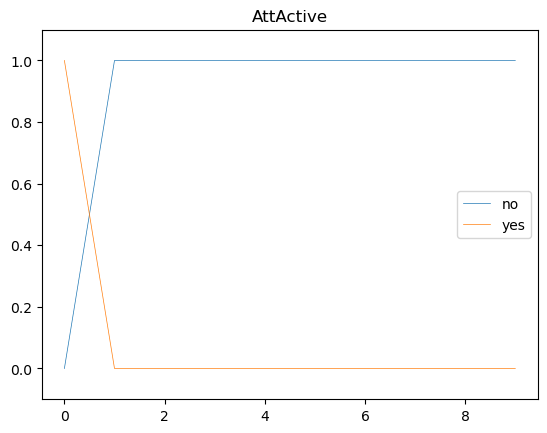

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000,1.000000e+00
1,0.000000,1.000000e+00
2,0.589858,4.101424e-01
3,0.975920,2.408001e-02
4,0.998939,1.060510e-03
5,0.999941,5.944286e-05
6,0.999997,3.490210e-06
7,1.000000,3.633106e-08
8,1.000000,1.868802e-10
9,1.000000,5.624992e-13


Plotting ('AttActive', ['no', 'yes']) for agent_j


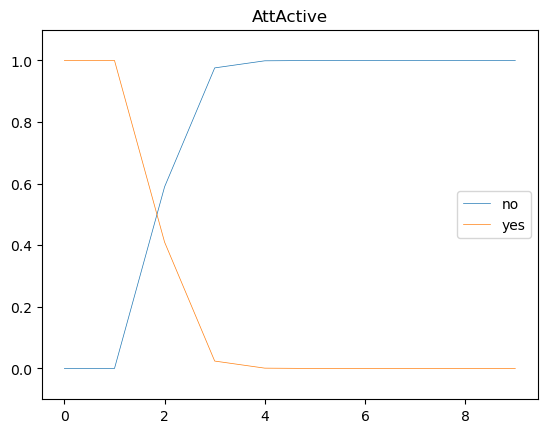

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for state:


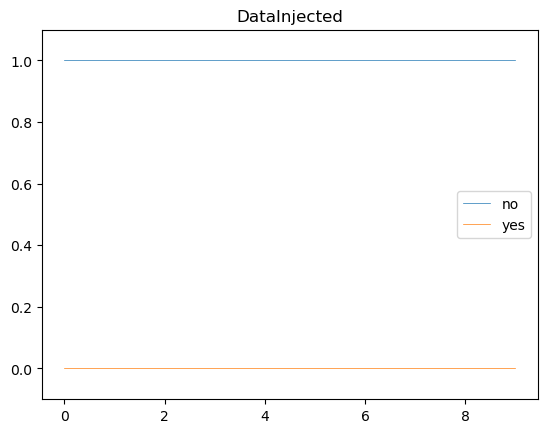

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_i


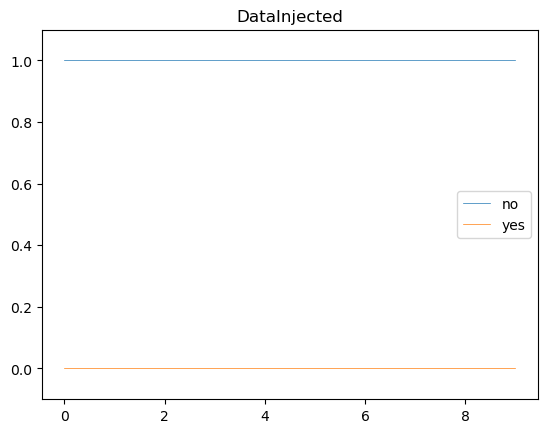

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,1.000000,0.000000
6,0.999997,0.000003
7,0.999997,0.000003
8,0.999997,0.000003
9,0.999997,0.000003


Plotting ('DataInjected', ['no', 'yes']) for agent_j


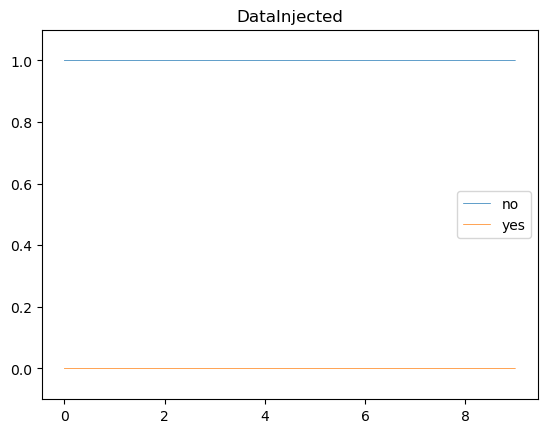

=============== End interaction trace


,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,Exit,auth|none|success|terminated|none,RestrictAccPrivs,none
1,Nop,auth|none|failure|terminated|none,Nop,login_activity
2,Nop,auth|user_files|success|terminated|none,Nop,none
3,Nop,denied|user_files|failure|terminated|none,Nop,none
4,Nop,denied|user_files|success|terminated|none,Nop,none
5,Nop,denied|user_files|failure|terminated|none,Nop,none
6,Nop,denied|user_files|success|terminated|none,Nop,none
7,Nop,denied|none|failure|terminated|none,Nop,none
8,Nop,auth|none|failure|terminated|none,Nop,none
9,Nop,auth|user_files|failure|terminated|none,Nop,none


Agent i's P(Aj)


,DecoyAccount,DeployData,LockAccounts,Nop,RestrictAccPrivs
0,0.0,0.0,0.0,0.75,0.25
1,0.0,0.0,0.0,1.00,0.00
2,0.0,0.0,0.0,1.00,0.00
3,0.0,0.0,0.0,1.00,0.00
4,0.0,0.0,0.0,1.00,0.00
5,0.0,0.0,0.0,1.00,0.00
6,0.0,0.0,0.0,1.00,0.00
7,0.0,0.0,0.0,1.00,0.00
8,0.0,0.0,0.0,1.00,0.00
9,0.0,0.0,0.0,1.00,0.00


Agent j's P(Aj)


,EnumAccounts,Exit,FileRecon,ManipulateData,Nop,PrivEscAcc
0,0.000000,0.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000
1,0.000000,7.800001e-02,1.820000e-01,7.400000e-01,0.000000,0.000000
2,0.601300,2.577000e-01,0.000000e+00,6.299999e-02,0.078000,0.000000
3,0.006922,2.750471e-02,0.000000e+00,0.000000e+00,0.895734,0.069840
4,0.000000,2.337852e-04,4.308446e-03,0.000000e+00,0.995133,0.000325
5,0.000000,5.185786e-07,5.044851e-05,2.227683e-04,0.999726,0.000000
6,0.000000,1.323095e-05,2.754048e-07,2.569353e-06,0.999984,0.000000
7,0.000000,1.527062e-07,9.143252e-10,1.371862e-08,1.000000,0.000000
8,0.000000,8.167174e-10,0.000000e+00,4.404436e-11,1.000000,0.000000
9,0.000000,2.590845e-12,0.000000e+00,0.000000e+00,1.000000,0.000000


,highCap,lowCap
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


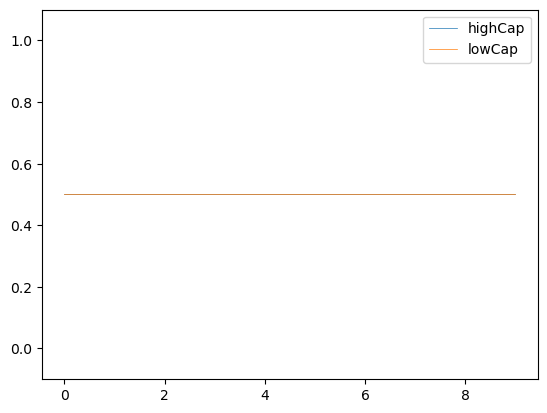

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


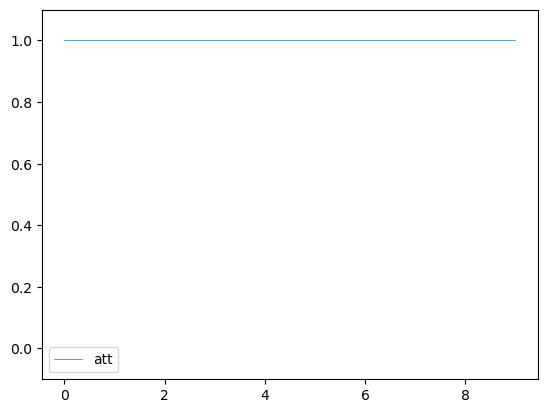

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


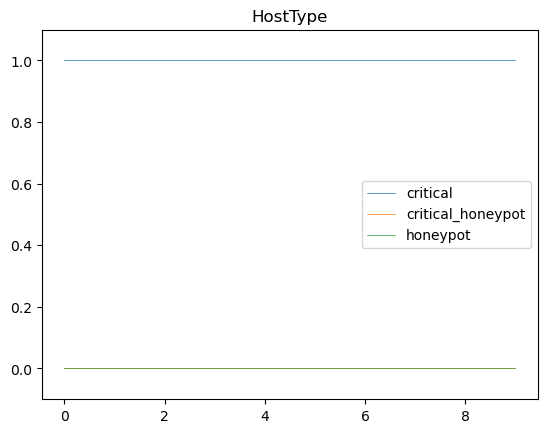

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.5,0.0,0.5
1,0.5,0.0,0.5
2,0.5,0.0,0.5
3,0.5,0.0,0.5
4,0.5,0.0,0.5
5,0.5,0.0,0.5
6,0.5,0.0,0.5
7,0.5,0.0,0.5
8,0.5,0.0,0.5
9,0.5,0.0,0.5


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


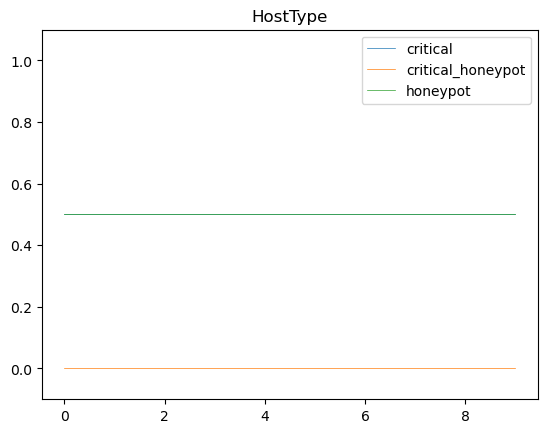

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


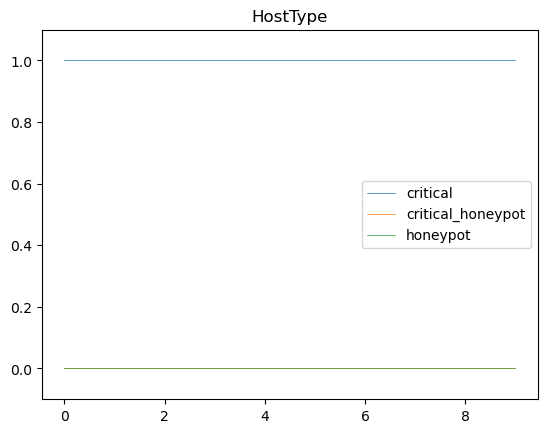

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for state:


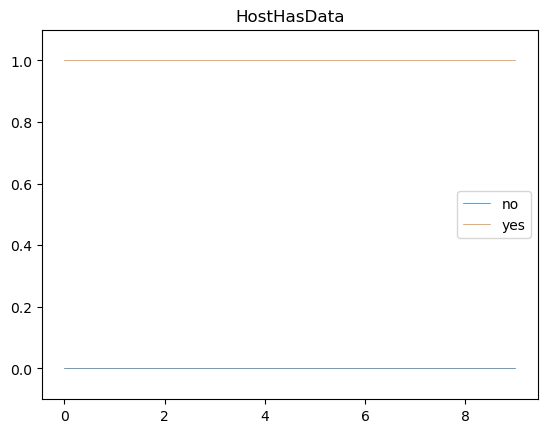

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('HostHasData', ['no', 'yes']) for agent_i


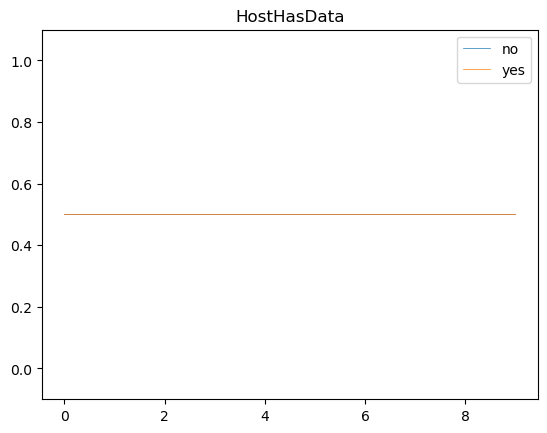

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


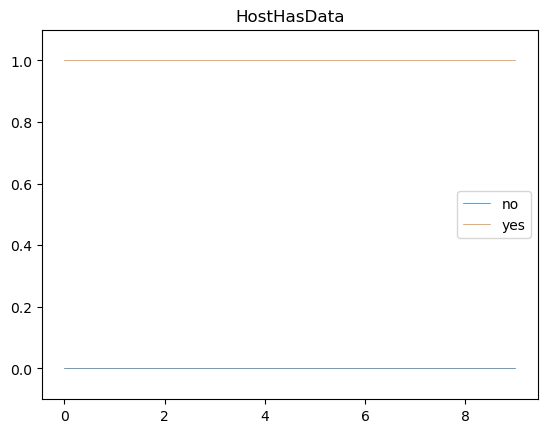

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


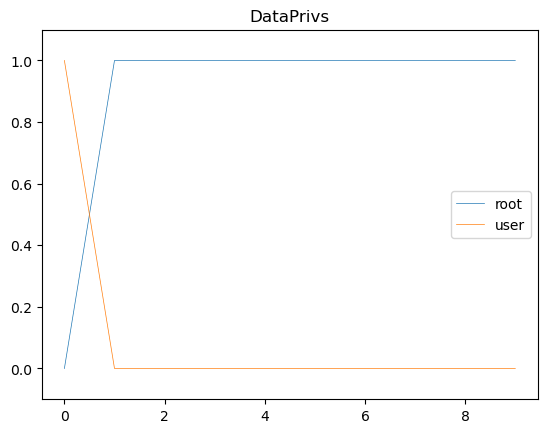

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.500,0.500
1,0.625,0.375
2,0.625,0.375
3,0.625,0.375
4,0.625,0.375
5,0.625,0.375
6,0.625,0.375
7,0.625,0.375
8,0.625,0.375
9,0.625,0.375


Plotting ('DataPrivs', ['root', 'user']) for agent_i


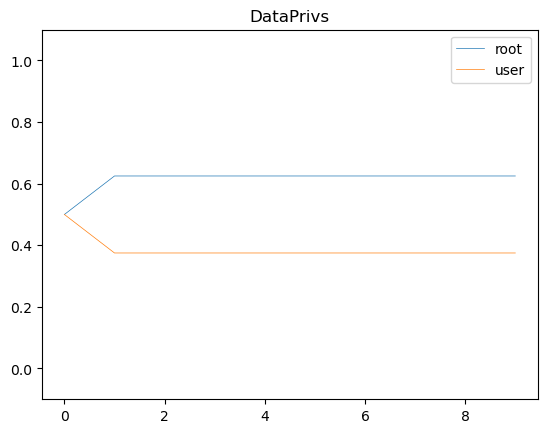

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


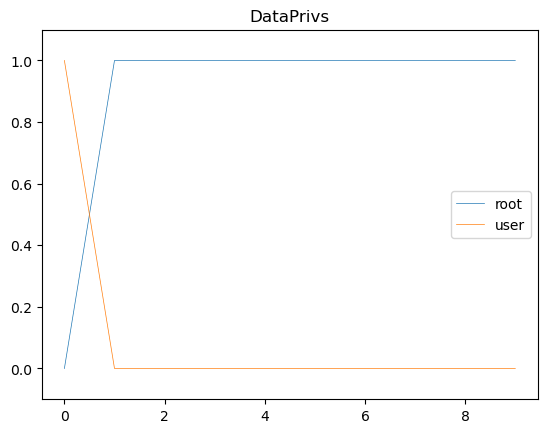

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


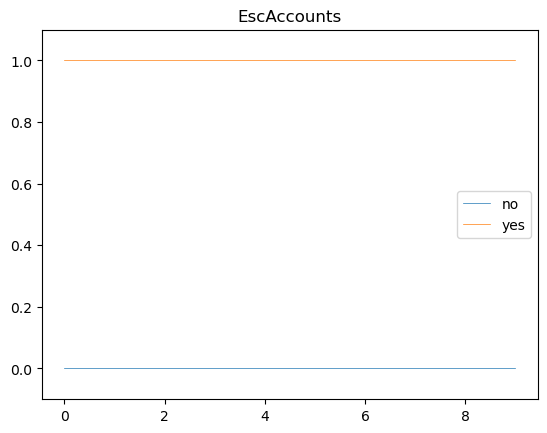

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


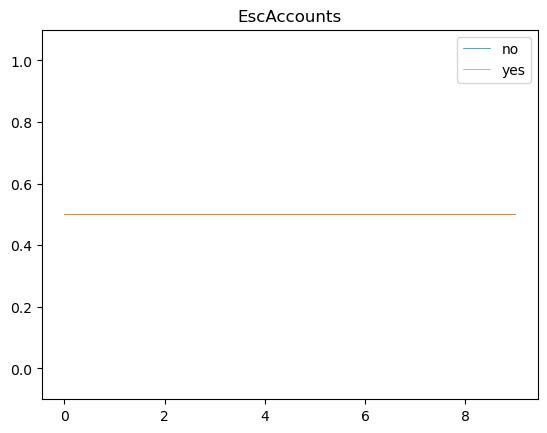

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


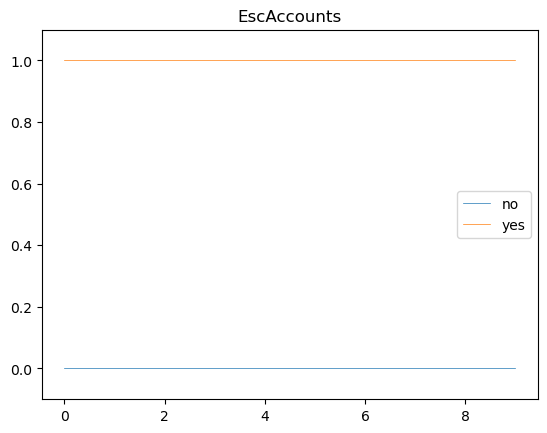

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for state:


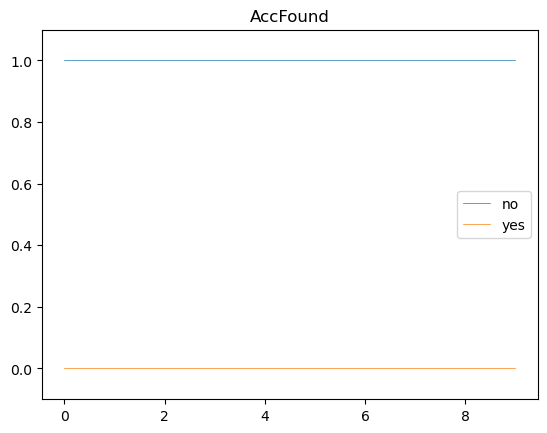

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for agent_i


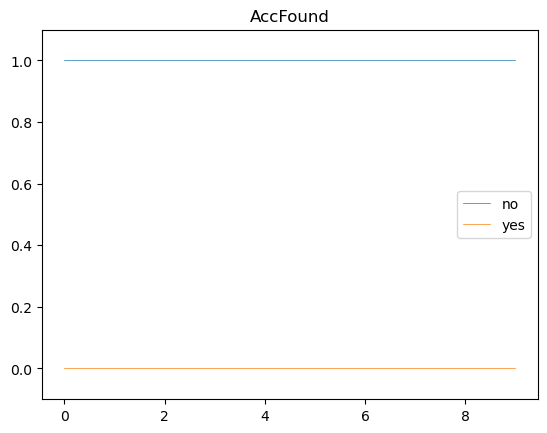

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,0.924498,0.075502
4,0.987202,0.012798
5,0.991518,0.008482
6,0.991773,0.008227
7,0.991775,0.008225
8,0.991775,0.008225
9,0.991775,0.008225


Plotting ('AccFound', ['no', 'yes']) for agent_j


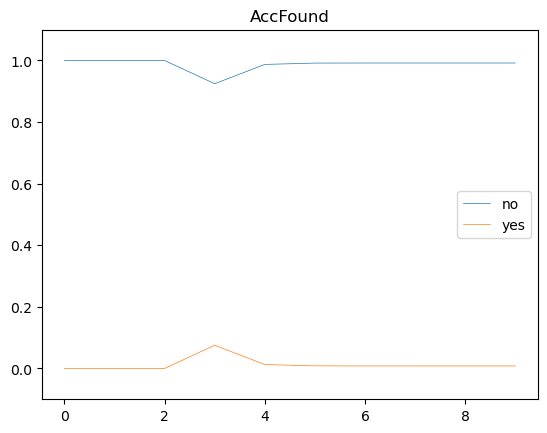

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for state:


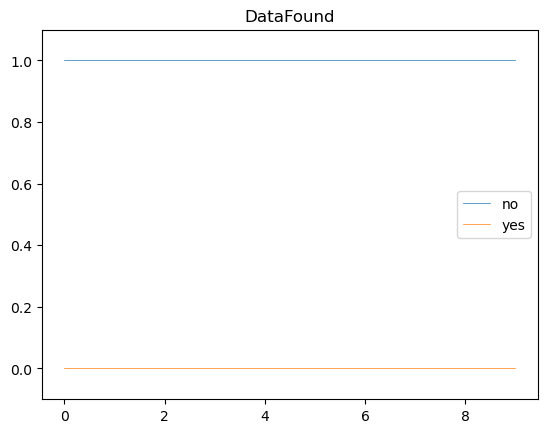

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for agent_i


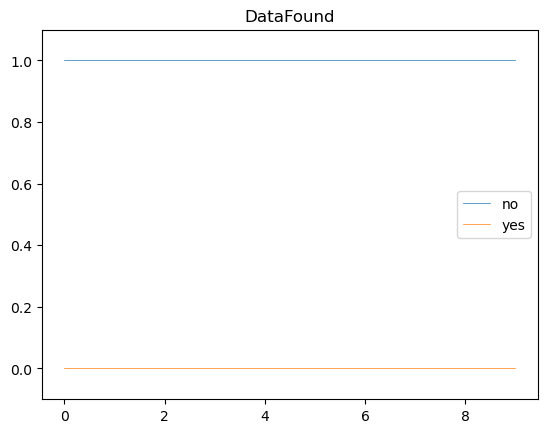

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,0.200000,0.800000
2,0.200000,0.800000
3,0.267504,0.732496
4,0.275928,0.724072
5,0.276411,0.723589
6,0.276470,0.723530
7,0.276471,0.723529
8,0.276471,0.723529
9,0.276471,0.723529


Plotting ('DataFound', ['no', 'yes']) for agent_j


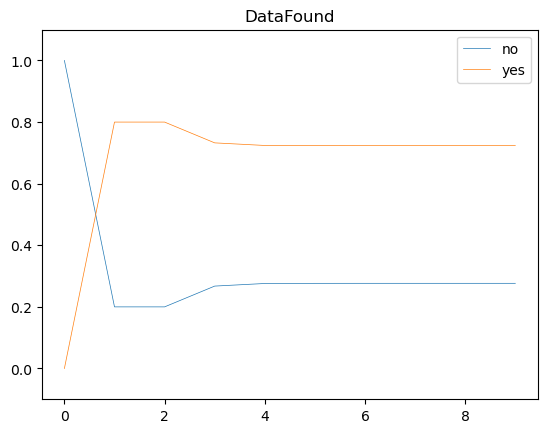

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for state:


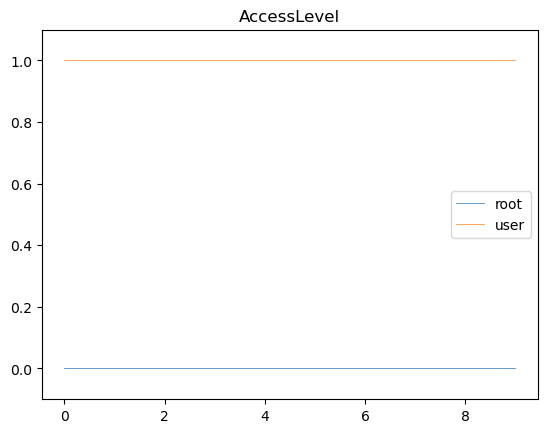

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


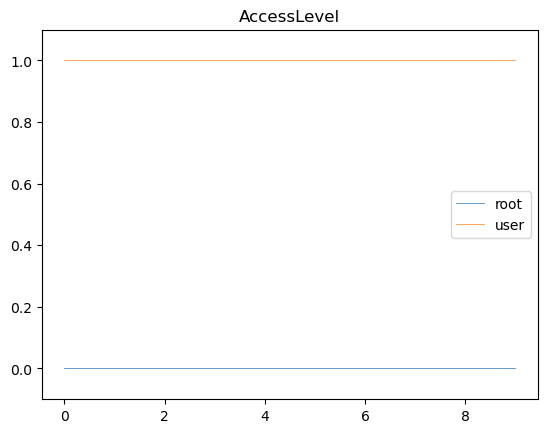

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.004308,0.995691
5,0.000273,0.999727
6,0.000016,0.999984
7,0.000013,0.999987
8,0.000013,0.999987
9,0.000013,0.999987


Plotting ('AccessLevel', ['root', 'user']) for agent_j


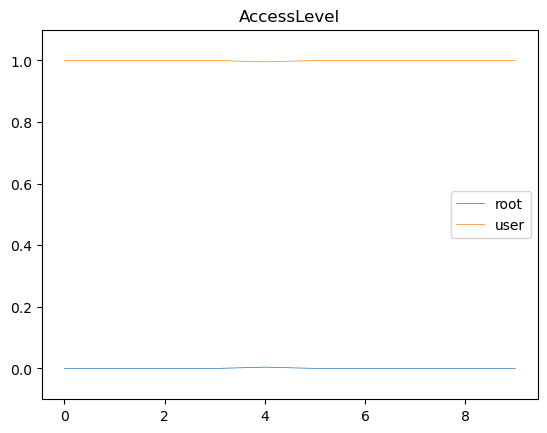

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


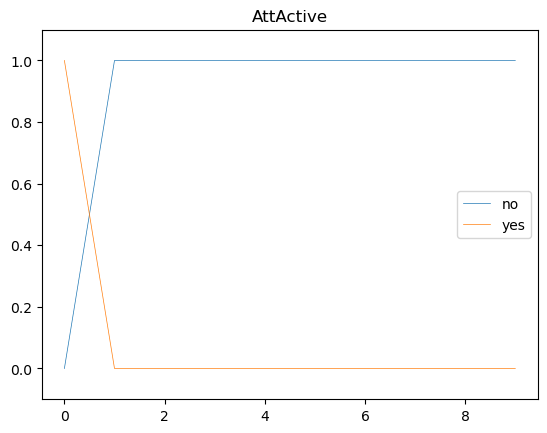

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


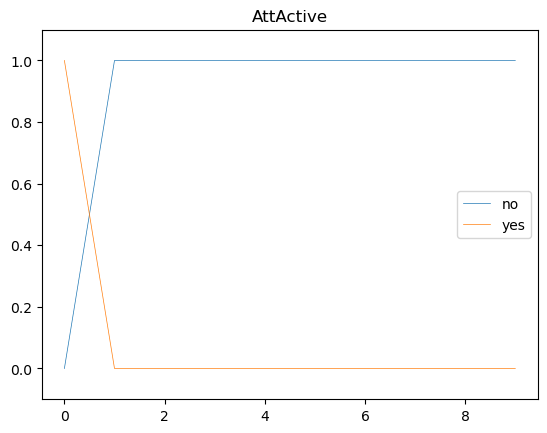

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000,1.000000e+00
1,0.000000,1.000000e+00
2,0.078000,9.219999e-01
3,0.895734,1.042661e-01
4,0.995133,4.866995e-03
5,0.999726,2.737354e-04
6,0.999984,1.607571e-05
7,1.000000,1.673391e-07
8,1.000000,8.607617e-10
9,1.000000,2.590845e-12


Plotting ('AttActive', ['no', 'yes']) for agent_j


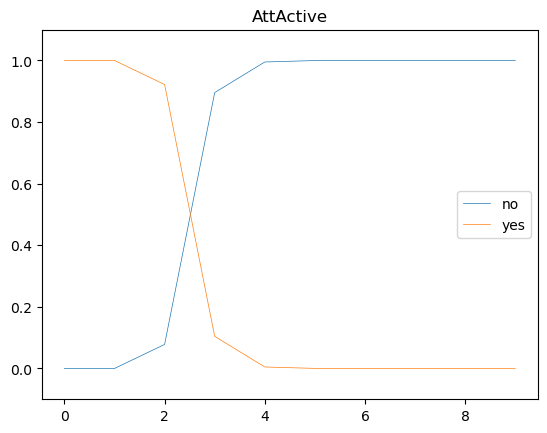

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for state:


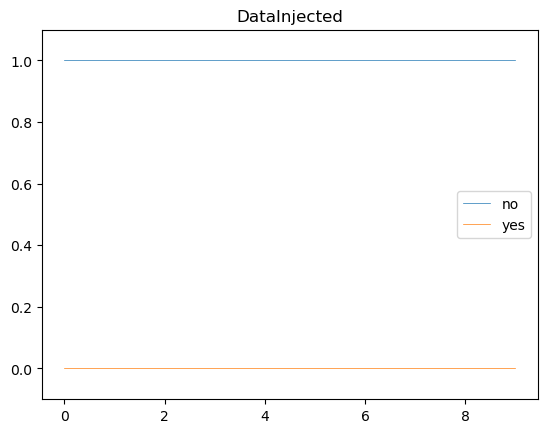

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_i


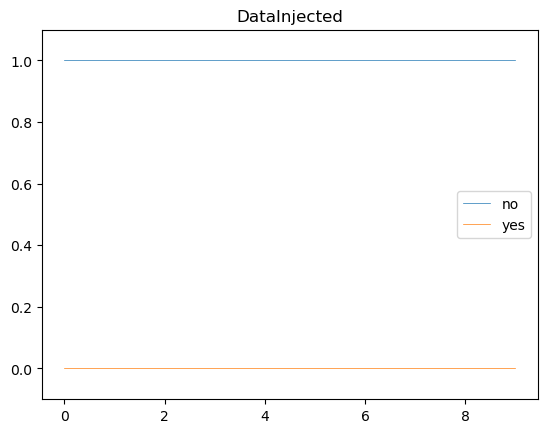

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,1.000000,0.000000
6,0.999987,0.000013
7,0.999987,0.000013
8,0.999987,0.000013
9,0.999987,0.000013


Plotting ('DataInjected', ['no', 'yes']) for agent_j


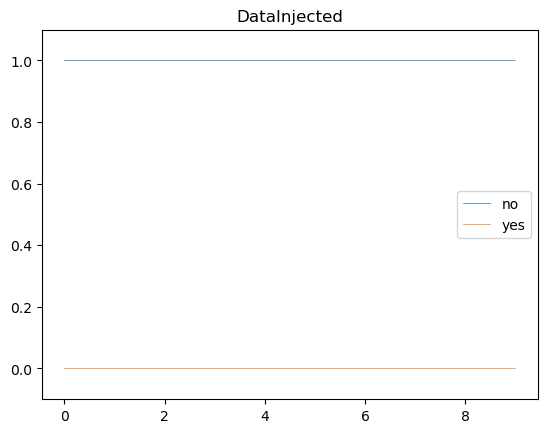

=============== End interaction trace


,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,Exit,denied|none|failure|terminated|none,RestrictAccPrivs,none
1,Nop,denied|none|success|terminated|none,Nop,none
2,Nop,denied|user_files|success|terminated|none,Nop,none
3,Nop,auth|none|success|terminated|none,Nop,none
4,Nop,auth|none|success|terminated|none,Nop,none
5,Nop,auth|user_files|success|terminated|none,Nop,none
6,Nop,denied|user_files|failure|terminated|none,Nop,none
7,Nop,denied|none|success|terminated|none,Nop,none
8,Nop,denied|none|failure|terminated|none,Nop,none
9,Nop,auth|none|failure|terminated|none,Nop,none


Agent i's P(Aj)


,DecoyAccount,DeployData,LockAccounts,Nop,RestrictAccPrivs
0,0.0,0.0,0.0,0.75,0.25
1,0.0,0.0,0.0,1.00,0.00
2,0.0,0.0,0.0,1.00,0.00
3,0.0,0.0,0.0,1.00,0.00
4,0.0,0.0,0.0,1.00,0.00
5,0.0,0.0,0.0,1.00,0.00
6,0.0,0.0,0.0,1.00,0.00
7,0.0,0.0,0.0,1.00,0.00
8,0.0,0.0,0.0,1.00,0.00
9,0.0,0.0,0.0,1.00,0.00


Agent j's P(Aj)


,EnumAccounts,Exit,FileRecon,ManipulateData,Nop,PrivEscAcc
0,0.000000,0.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000
1,0.000000,7.800001e-02,1.820000e-01,7.400000e-01,0.000000,0.000000
2,0.267482,1.146352e-01,0.000000e+00,2.802491e-02,0.589858,0.000000
3,0.001599,6.352148e-03,0.000000e+00,0.000000e+00,0.975920,0.016129
4,0.000000,5.094138e-05,9.388030e-04,0.000000e+00,0.998939,0.000071
5,0.000000,1.126116e-07,1.095512e-05,4.837513e-05,0.999941,0.000000
6,0.000000,2.872582e-06,5.979335e-08,5.578343e-07,0.999997,0.000000
7,0.000000,3.315410e-08,1.985095e-10,2.978455e-09,1.000000,0.000000
8,0.000000,1.773177e-10,0.000000e+00,9.562487e-12,1.000000,0.000000
9,0.000000,5.624992e-13,0.000000e+00,0.000000e+00,1.000000,0.000000


,highCap,lowCap
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


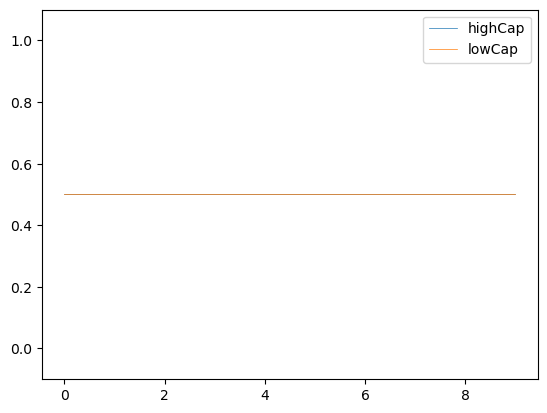

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


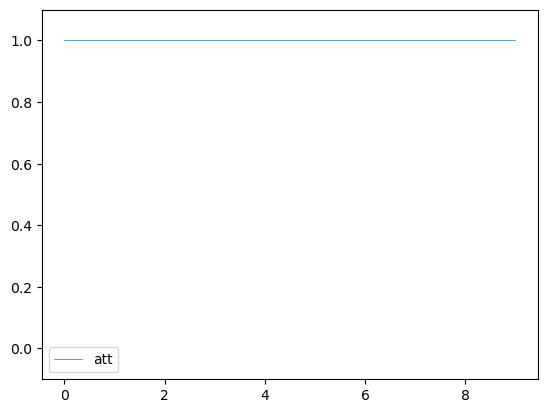

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


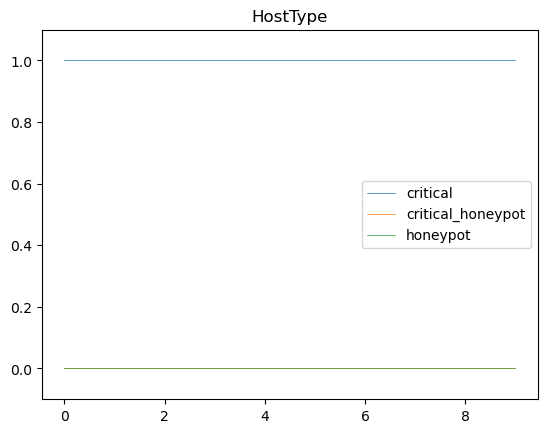

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.5,0.0,0.5
1,0.5,0.0,0.5
2,0.5,0.0,0.5
3,0.5,0.0,0.5
4,0.5,0.0,0.5
5,0.5,0.0,0.5
6,0.5,0.0,0.5
7,0.5,0.0,0.5
8,0.5,0.0,0.5
9,0.5,0.0,0.5


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


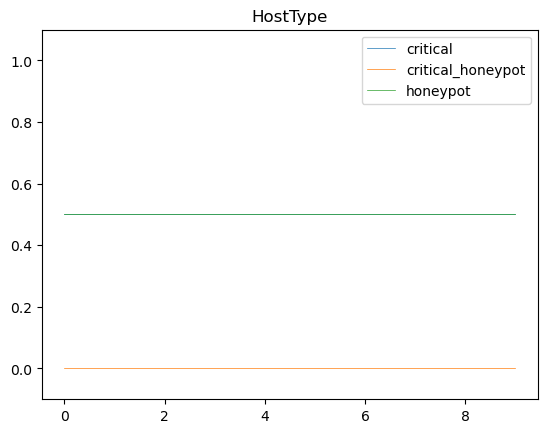

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


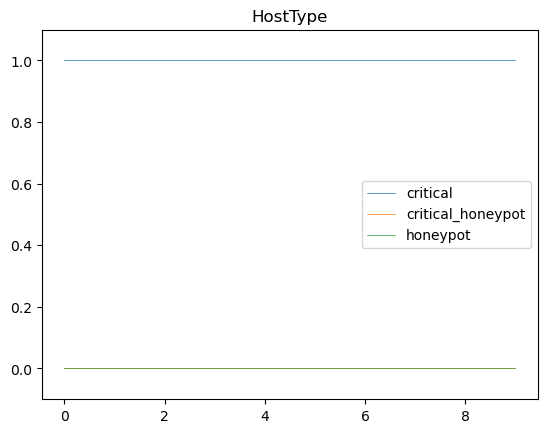

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for state:


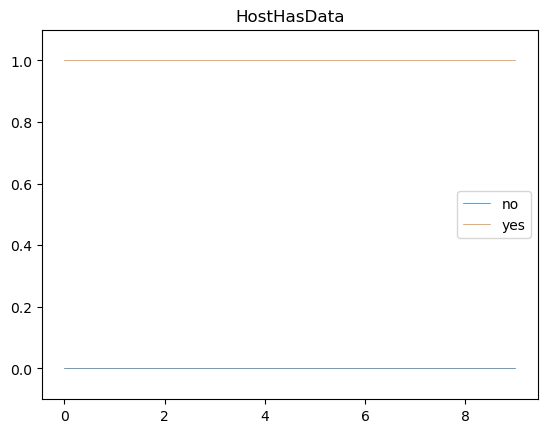

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('HostHasData', ['no', 'yes']) for agent_i


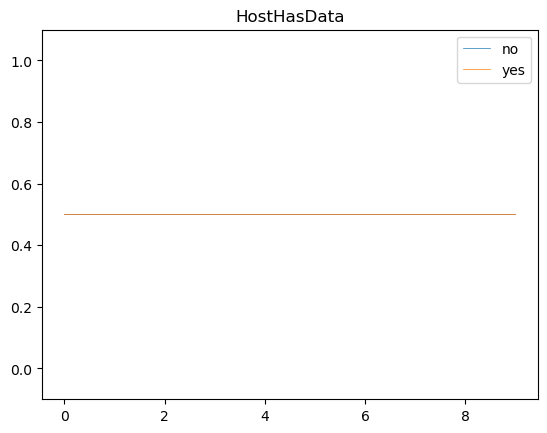

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


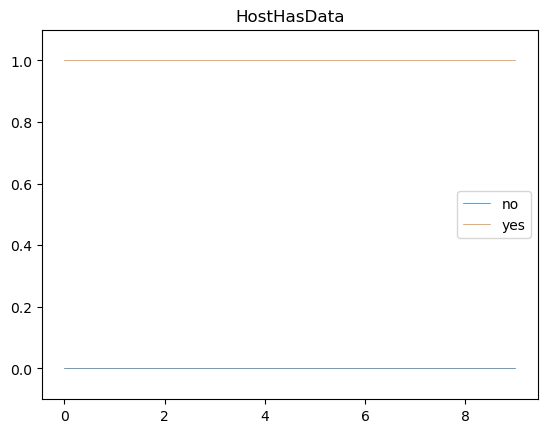

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


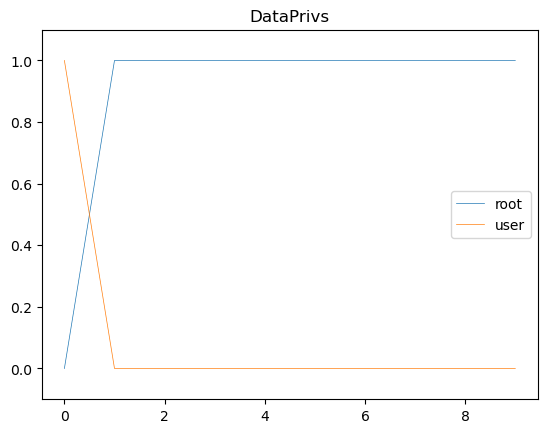

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.500,0.500
1,0.625,0.375
2,0.625,0.375
3,0.625,0.375
4,0.625,0.375
5,0.625,0.375
6,0.625,0.375
7,0.625,0.375
8,0.625,0.375
9,0.625,0.375


Plotting ('DataPrivs', ['root', 'user']) for agent_i


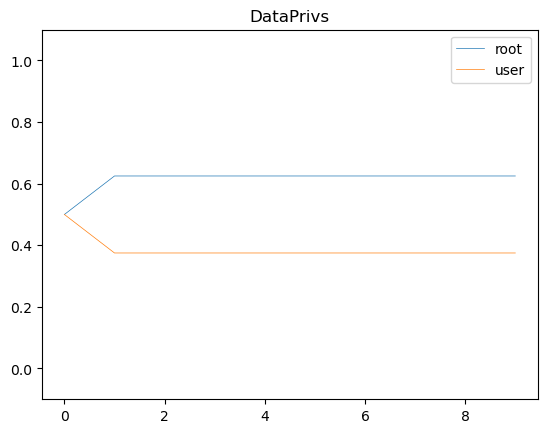

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


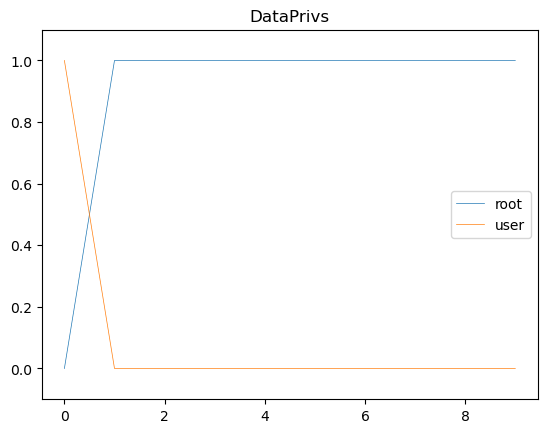

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


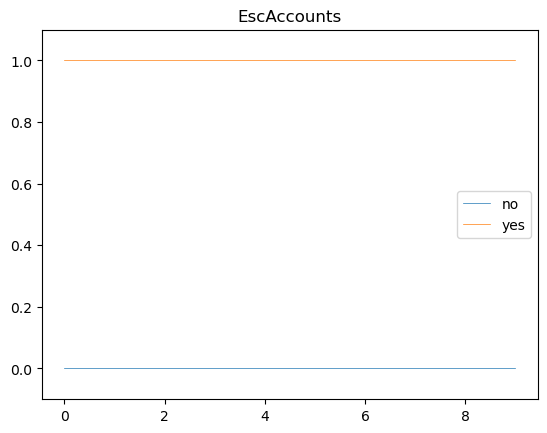

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


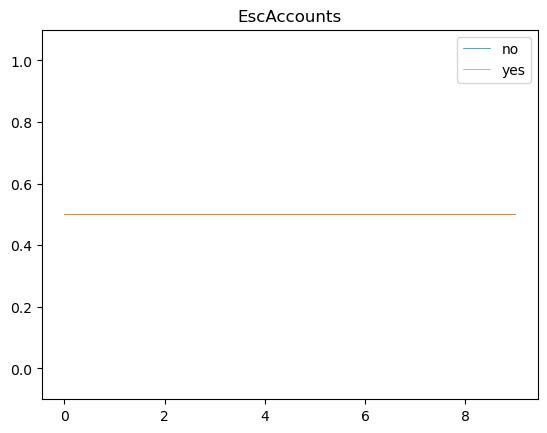

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


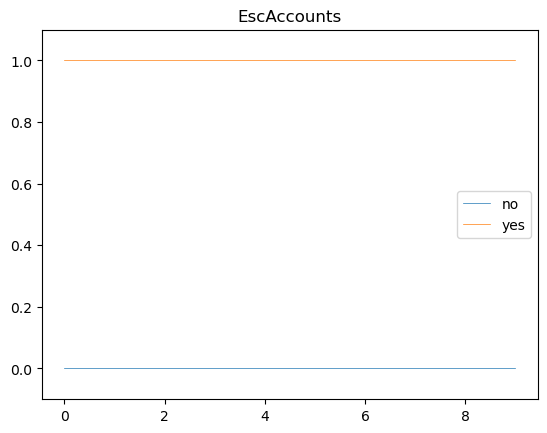

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for state:


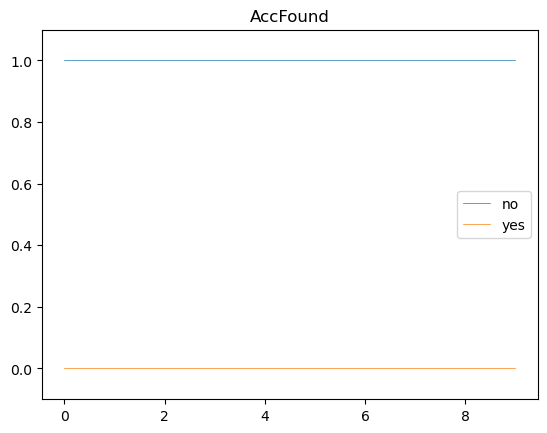

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for agent_i


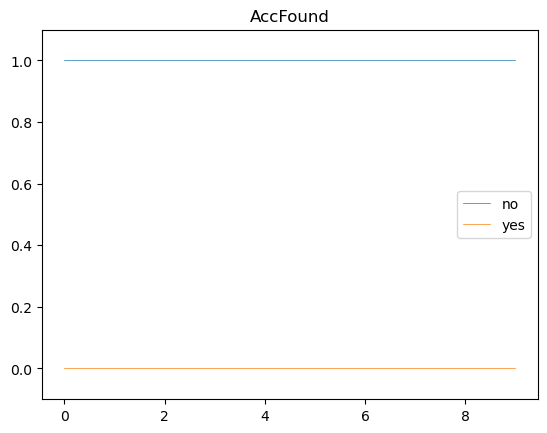

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,0.982563,0.017437
4,0.997211,0.002789
5,0.998158,0.001842
6,0.998214,0.001786
7,0.998214,0.001786
8,0.998214,0.001786
9,0.998214,0.001786


Plotting ('AccFound', ['no', 'yes']) for agent_j


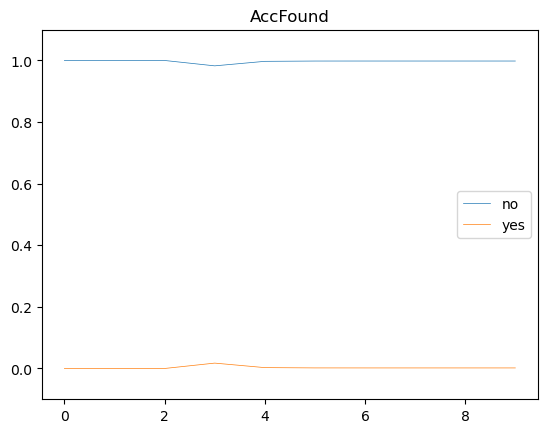

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for state:


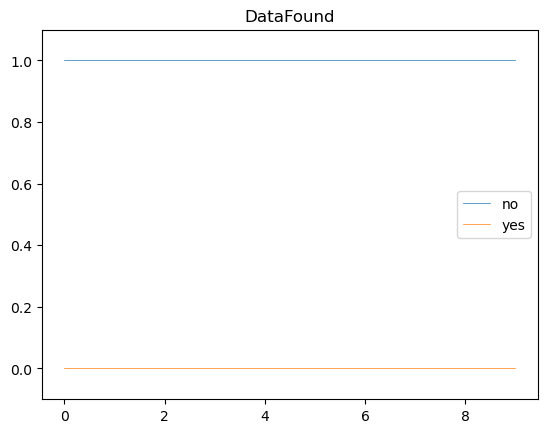

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for agent_i


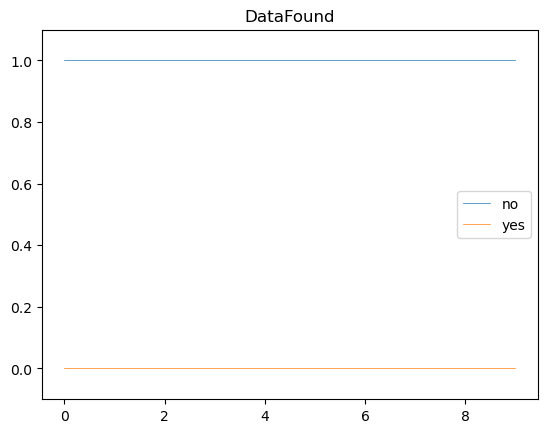

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,0.200000,0.800000
2,0.473310,0.526690
3,0.594200,0.405800
4,0.601579,0.398421
5,0.601994,0.398006
6,0.602025,0.397975
7,0.602025,0.397975
8,0.602025,0.397975
9,0.602025,0.397975


Plotting ('DataFound', ['no', 'yes']) for agent_j


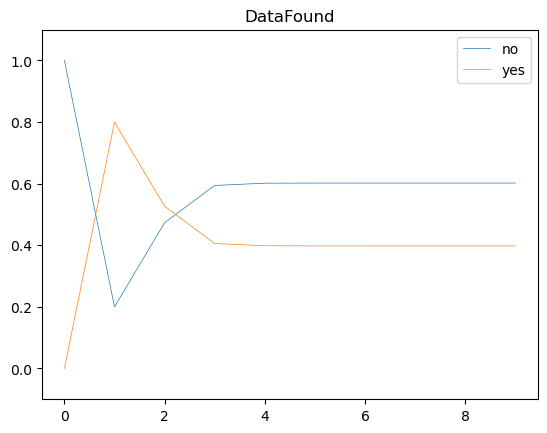

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for state:


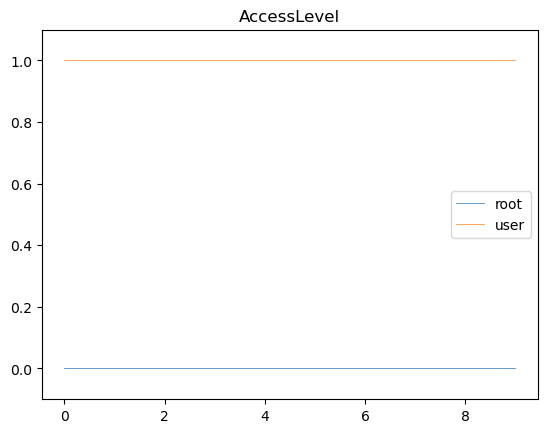

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


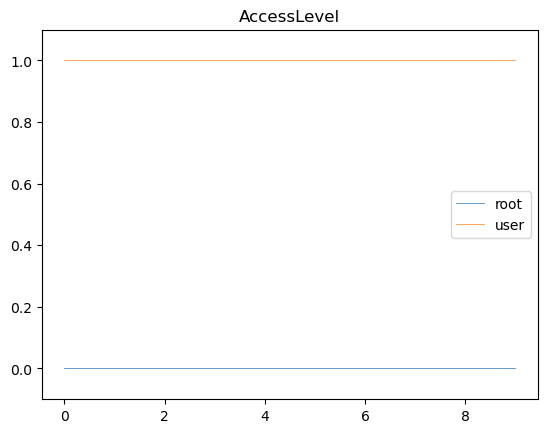

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.000939,0.999061
5,0.000059,0.999941
6,0.000003,0.999997
7,0.000003,0.999997
8,0.000003,0.999997
9,0.000003,0.999997


Plotting ('AccessLevel', ['root', 'user']) for agent_j


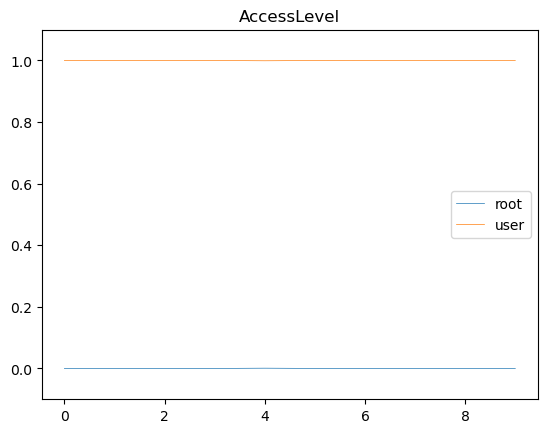

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


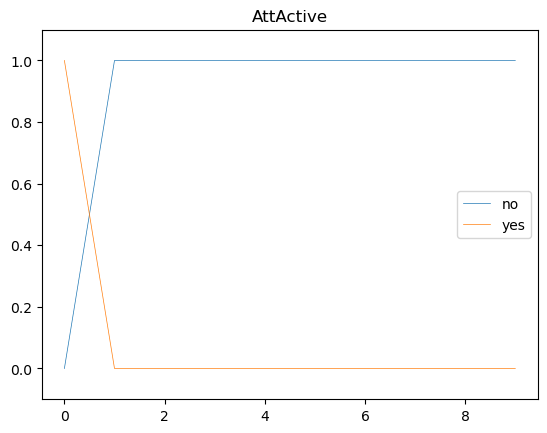

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


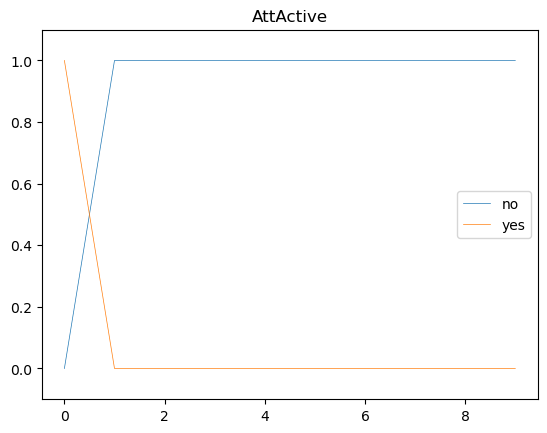

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000,1.000000e+00
1,0.000000,1.000000e+00
2,0.589858,4.101424e-01
3,0.975920,2.408001e-02
4,0.998939,1.060510e-03
5,0.999941,5.944286e-05
6,0.999997,3.490210e-06
7,1.000000,3.633106e-08
8,1.000000,1.868802e-10
9,1.000000,5.624992e-13


Plotting ('AttActive', ['no', 'yes']) for agent_j


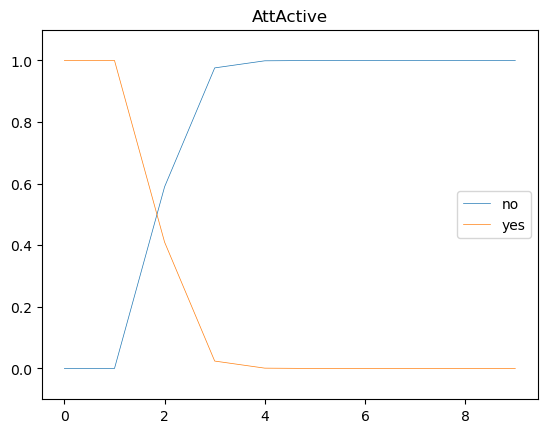

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for state:


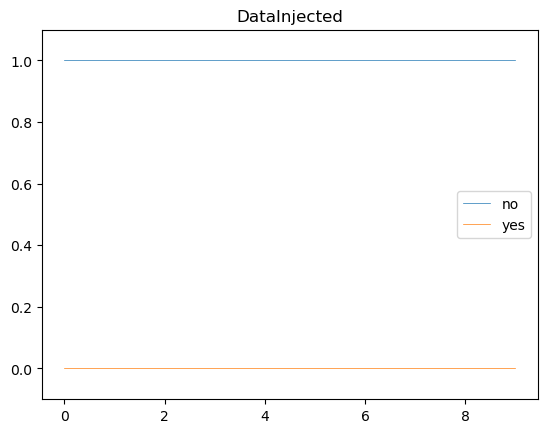

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_i


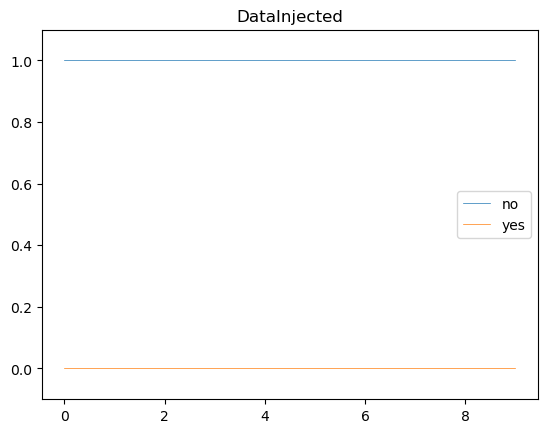

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,1.000000,0.000000
6,0.999997,0.000003
7,0.999997,0.000003
8,0.999997,0.000003
9,0.999997,0.000003


Plotting ('DataInjected', ['no', 'yes']) for agent_j


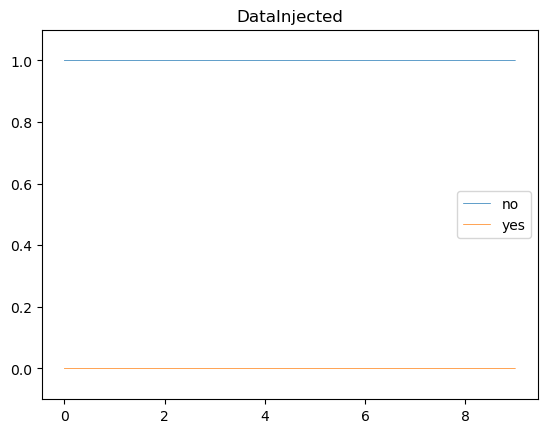

=============== End interaction trace


,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,Exit,denied|none|success|terminated|none,RestrictAccPrivs,none
1,Nop,denied|none|failure|terminated|none,Nop,none
2,Nop,auth|user_files|failure|terminated|none,Nop,none
3,Nop,denied|user_files|failure|terminated|none,Nop,login_activity
4,Nop,auth|user_files|failure|terminated|none,Nop,none
5,Nop,auth|none|failure|terminated|none,Nop,none
6,Nop,auth|user_files|success|terminated|none,Nop,none
7,Nop,denied|user_files|failure|terminated|none,Nop,none
8,Nop,auth|user_files|failure|terminated|none,Nop,none
9,Nop,denied|user_files|failure|terminated|none,Nop,none


Agent i's P(Aj)


,DecoyAccount,DeployData,LockAccounts,Nop,RestrictAccPrivs
0,0.0,0.0,0.0,0.75,0.25
1,0.0,0.0,0.0,1.00,0.00
2,0.0,0.0,0.0,1.00,0.00
3,0.0,0.0,0.0,1.00,0.00
4,0.0,0.0,0.0,1.00,0.00
5,0.0,0.0,0.0,1.00,0.00
6,0.0,0.0,0.0,1.00,0.00
7,0.0,0.0,0.0,1.00,0.00
8,0.0,0.0,0.0,1.00,0.00
9,0.0,0.0,0.0,1.00,0.00


Agent j's P(Aj)


,EnumAccounts,Exit,FileRecon,ManipulateData,Nop,PrivEscAcc
0,0.000000,0.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000
1,0.000000,7.800001e-02,1.820000e-01,7.400000e-01,0.000000,0.000000
2,0.267482,1.146352e-01,0.000000e+00,2.802491e-02,0.589858,0.000000
3,0.001599,6.352148e-03,0.000000e+00,0.000000e+00,0.975920,0.016129
4,0.000000,6.220951e-03,2.120609e-01,0.000000e+00,0.780778,0.000940
5,0.000000,1.869708e-06,2.015169e-03,1.365405e-02,0.984329,0.000000
6,0.000000,8.228868e-04,8.641165e-06,1.039876e-04,0.999064,0.000000
7,0.000000,6.196863e-06,3.345382e-09,4.257138e-07,0.999993,0.000000
8,0.000000,2.507763e-08,0.000000e+00,1.611520e-10,1.000000,0.000000
9,0.000000,9.479527e-12,0.000000e+00,0.000000e+00,1.000000,0.000000


,highCap,lowCap
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


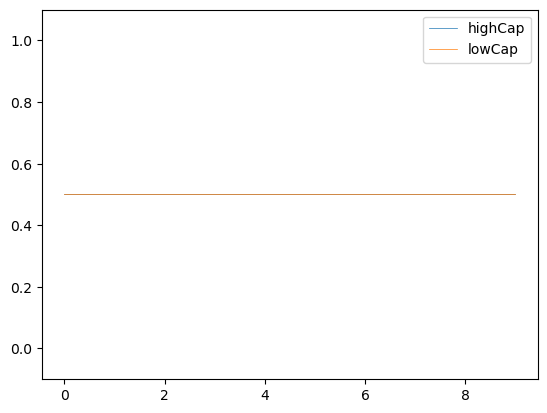

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


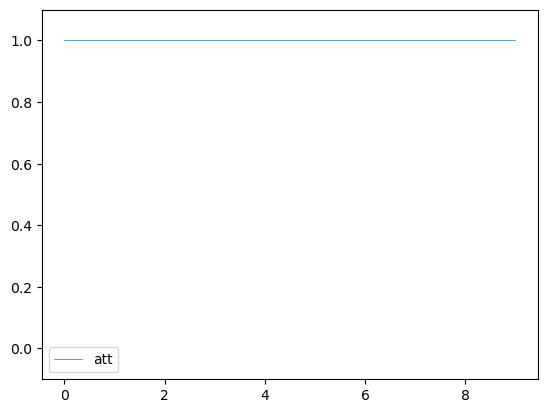

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


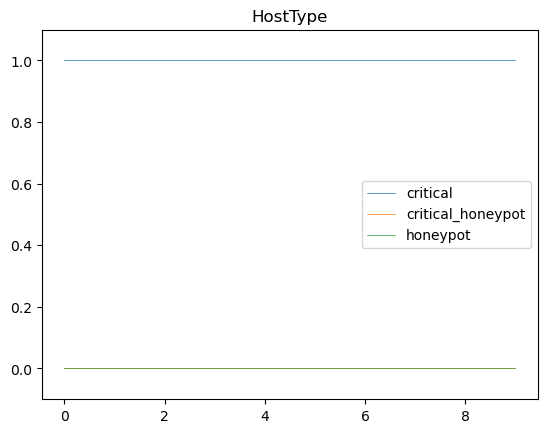

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.5,0.0,0.5
1,0.5,0.0,0.5
2,0.5,0.0,0.5
3,0.5,0.0,0.5
4,0.5,0.0,0.5
5,0.5,0.0,0.5
6,0.5,0.0,0.5
7,0.5,0.0,0.5
8,0.5,0.0,0.5
9,0.5,0.0,0.5


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


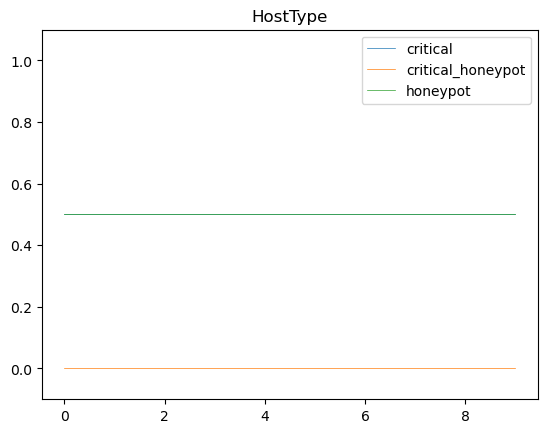

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


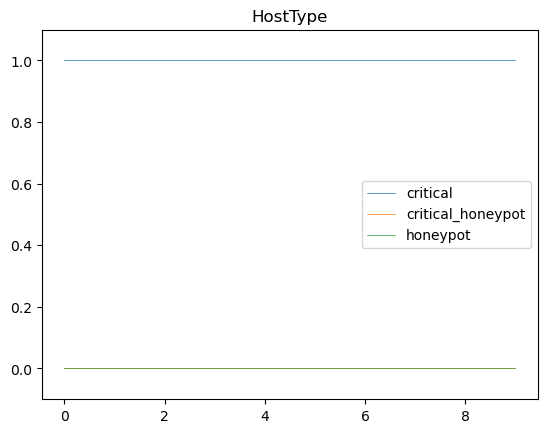

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for state:


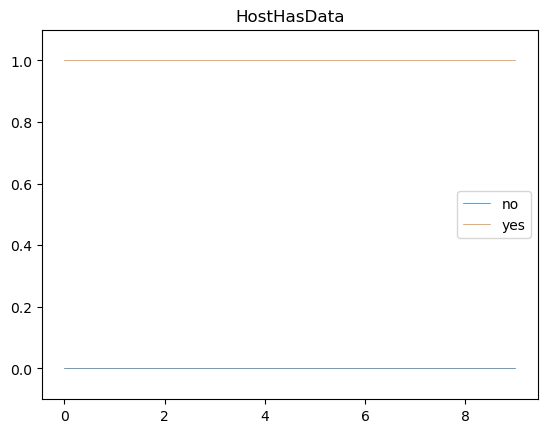

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('HostHasData', ['no', 'yes']) for agent_i


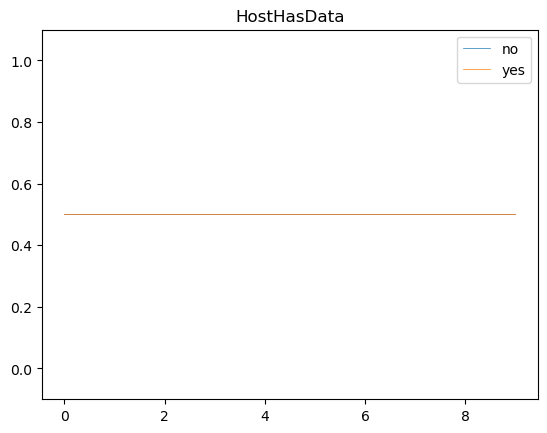

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


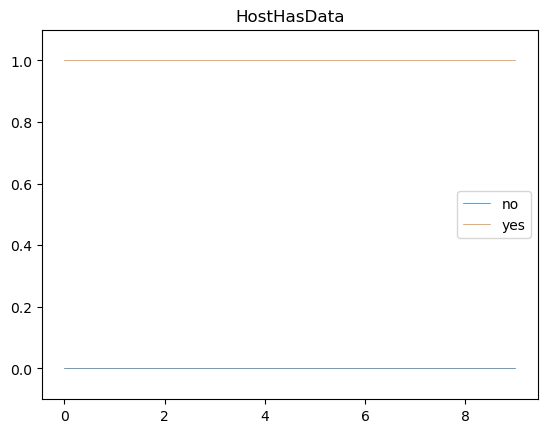

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


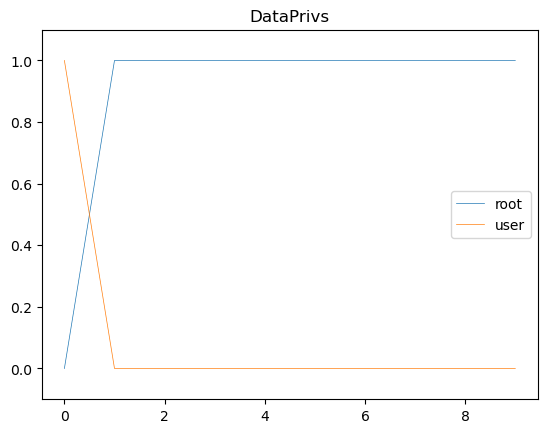

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.500,0.500
1,0.625,0.375
2,0.625,0.375
3,0.625,0.375
4,0.625,0.375
5,0.625,0.375
6,0.625,0.375
7,0.625,0.375
8,0.625,0.375
9,0.625,0.375


Plotting ('DataPrivs', ['root', 'user']) for agent_i


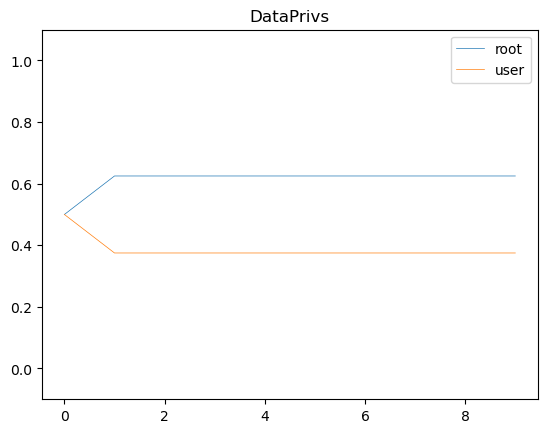

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


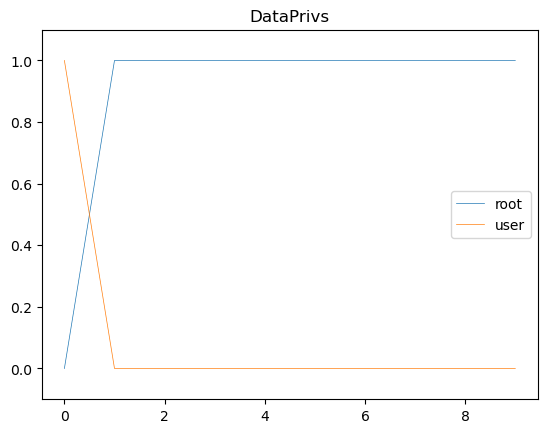

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


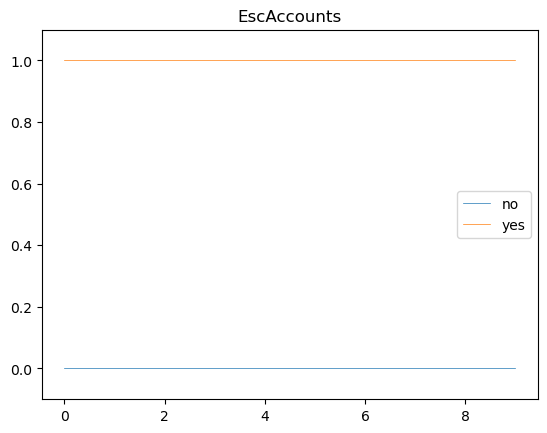

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


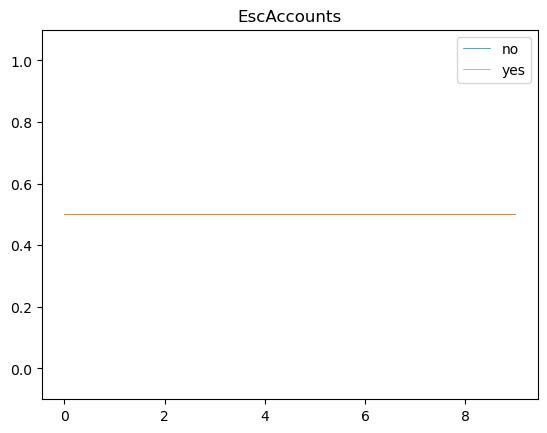

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


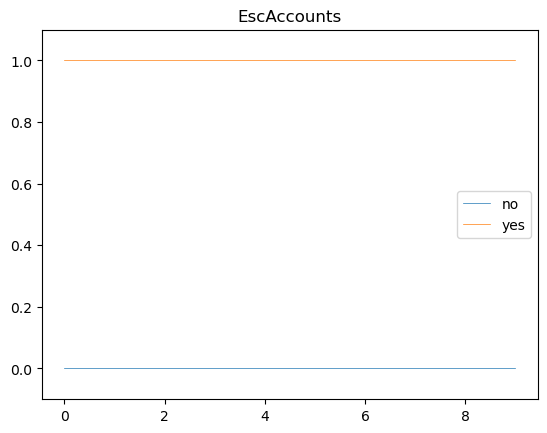

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for state:


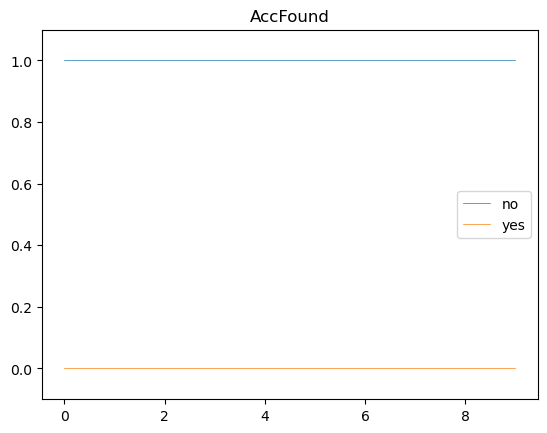

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for agent_i


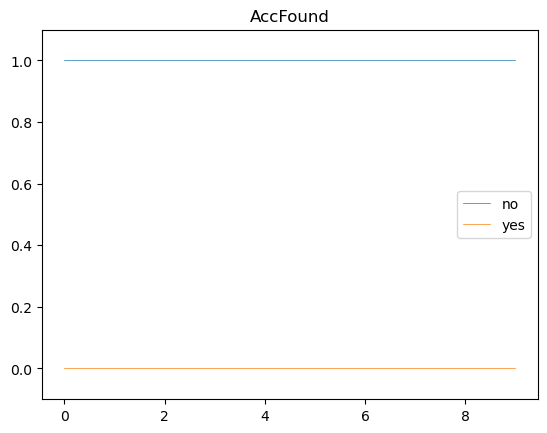

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,0.982563,0.017437
4,0.785536,0.214463
5,0.982470,0.017530
6,0.997176,0.002824
7,0.997282,0.002718
8,0.997282,0.002718
9,0.997282,0.002718


Plotting ('AccFound', ['no', 'yes']) for agent_j


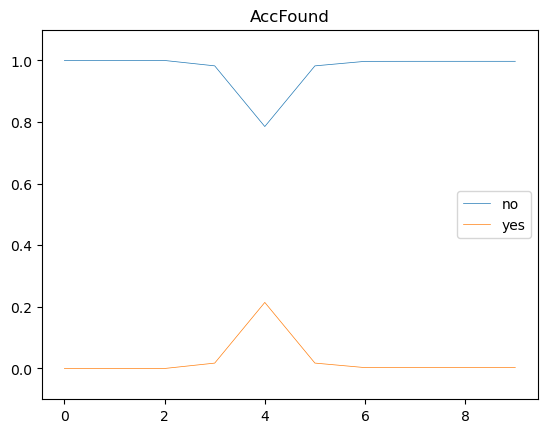

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for state:


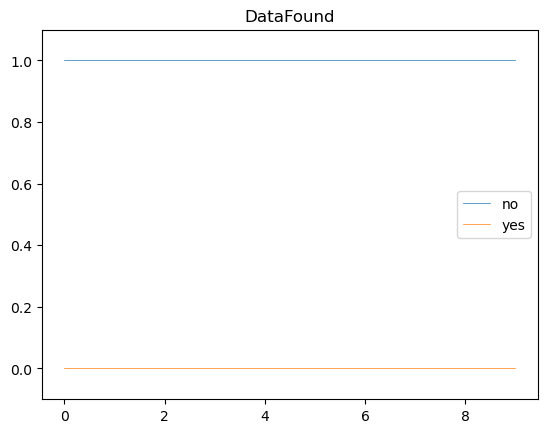

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for agent_i


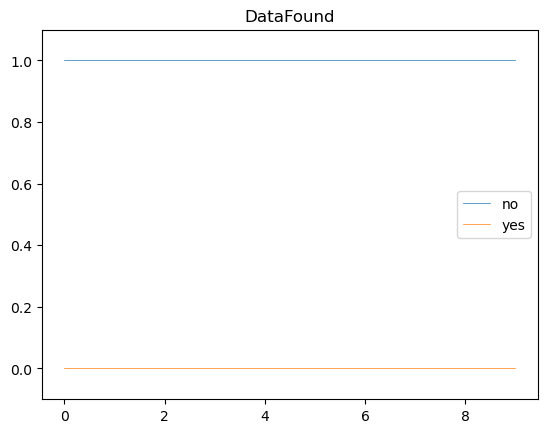

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,0.200000,0.800000
2,0.473310,0.526690
3,0.594200,0.405800
4,0.504168,0.495832
5,0.589655,0.410345
6,0.597984,0.402016
7,0.598043,0.401957
8,0.598043,0.401957
9,0.598043,0.401957


Plotting ('DataFound', ['no', 'yes']) for agent_j


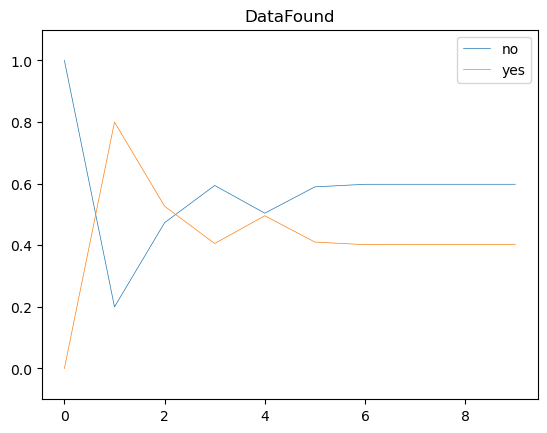

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for state:


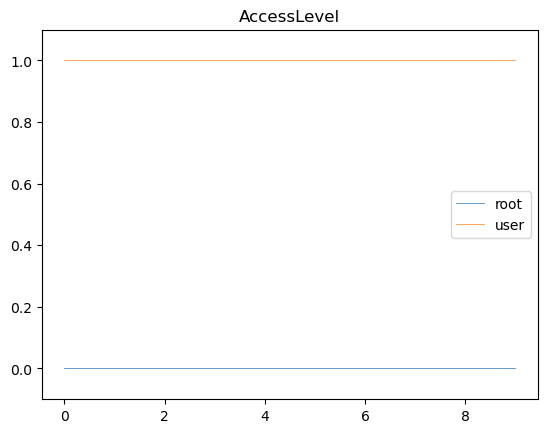

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


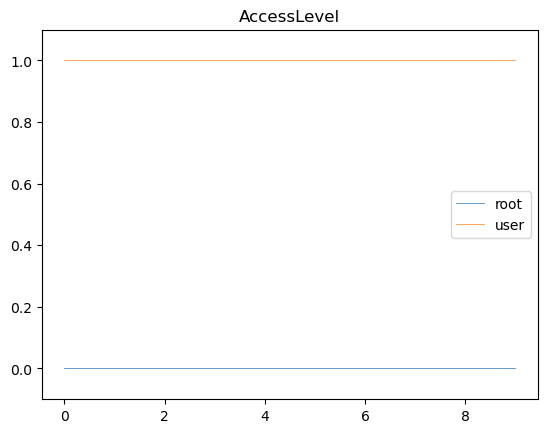

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.212061,0.787939
5,0.015669,0.984331
6,0.000936,0.999064
7,0.000830,0.999171
8,0.000829,0.999171
9,0.000829,0.999171


Plotting ('AccessLevel', ['root', 'user']) for agent_j


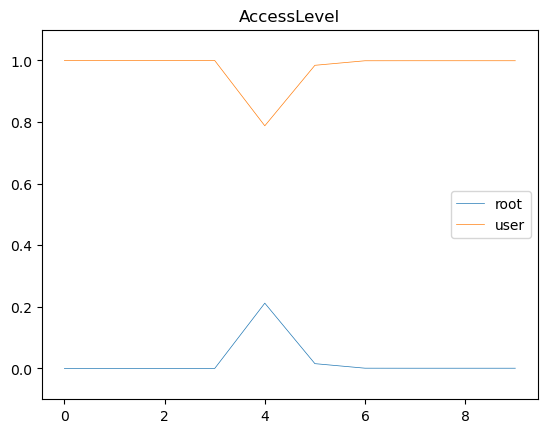

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


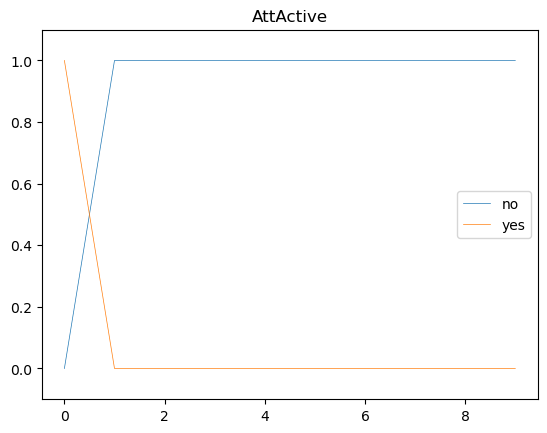

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


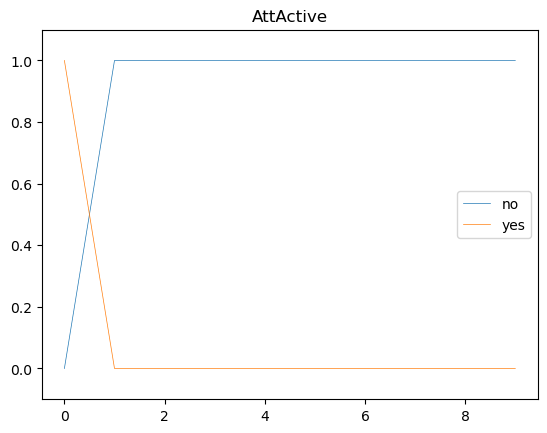

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000,1.000000e+00
1,0.000000,1.000000e+00
2,0.589858,4.101424e-01
3,0.975920,2.408001e-02
4,0.780778,2.192222e-01
5,0.984329,1.567109e-02
6,0.999064,9.355156e-04
7,0.999993,6.625922e-06
8,1.000000,2.523878e-08
9,1.000000,9.479527e-12


Plotting ('AttActive', ['no', 'yes']) for agent_j


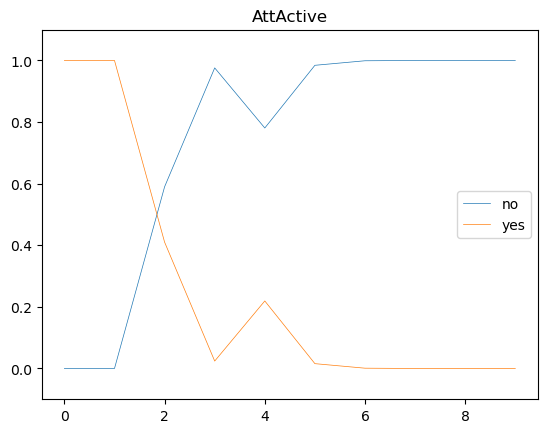

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for state:


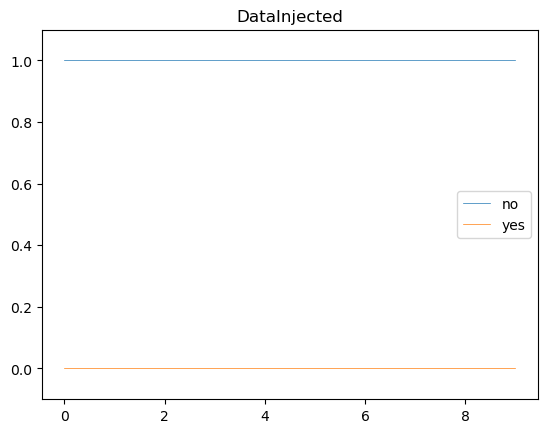

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_i


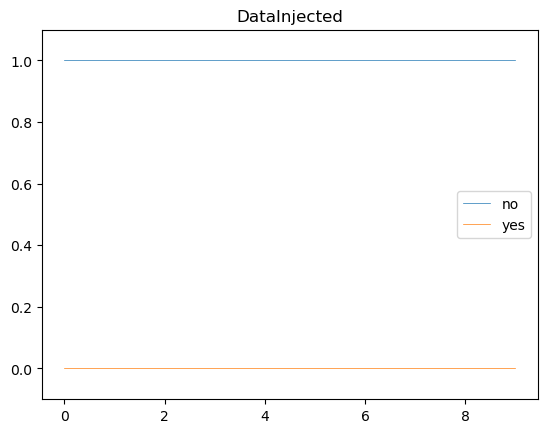

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,1.000000,0.000000
6,0.999188,0.000812
7,0.999182,0.000818
8,0.999182,0.000818
9,0.999182,0.000818


Plotting ('DataInjected', ['no', 'yes']) for agent_j


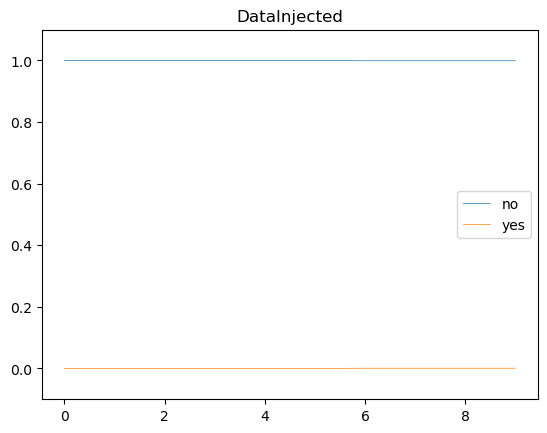

=============== End interaction trace


,i_acts,"[""AccessPerm'"", ""HostObs'"", ""ActionResult'"", ""ConnStatus'"", ""DefenseObs'""]",j_acts,"[""EndPtAlerts'""]"
0,Exit,denied|none|success|terminated|none,RestrictAccPrivs,file_write
1,Nop,denied|user_files|success|terminated|none,Nop,login_activity
2,Nop,denied|none|failure|terminated|none,Nop,none
3,Nop,denied|user_files|failure|terminated|none,Nop,none
4,Nop,denied|none|success|terminated|none,Nop,none
5,Nop,denied|user_files|success|terminated|none,Nop,none
6,Nop,auth|none|failure|terminated|none,Nop,none
7,Nop,denied|none|failure|terminated|none,Nop,none
8,Nop,denied|user_files|failure|terminated|none,Nop,file_enum
9,Nop,denied|user_files|failure|terminated|none,Nop,none


Agent i's P(Aj)


,DecoyAccount,DeployData,LockAccounts,Nop,RestrictAccPrivs
0,0.0,0.0,0.0,0.75,0.25
1,0.0,0.0,0.0,1.00,0.00
2,0.0,0.0,0.0,1.00,0.00
3,0.0,0.0,0.0,1.00,0.00
4,0.0,0.0,0.0,1.00,0.00
5,0.0,0.0,0.0,1.00,0.00
6,0.0,0.0,0.0,1.00,0.00
7,0.0,0.0,0.0,1.00,0.00
8,0.0,0.0,0.0,1.00,0.00
9,0.0,0.0,0.0,1.00,0.00


Agent j's P(Aj)


,EnumAccounts,Exit,FileRecon,ManipulateData,Nop,PrivEscAcc
0,0.000000,0.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000
1,0.000000,7.800001e-02,1.820000e-01,7.400000e-01,0.000000,0.000000
2,0.601300,2.577000e-01,0.000000e+00,6.299999e-02,0.078000,0.000000
3,0.006922,2.750471e-02,0.000000e+00,0.000000e+00,0.895734,0.069840
4,0.000000,2.337852e-04,4.308446e-03,0.000000e+00,0.995133,0.000325
5,0.000000,5.185786e-07,5.044851e-05,2.227683e-04,0.999726,0.000000
6,0.000000,1.323095e-05,2.754048e-07,2.569353e-06,0.999984,0.000000
7,0.000000,1.527062e-07,9.143252e-10,1.371862e-08,1.000000,0.000000
8,0.000000,8.167174e-10,0.000000e+00,4.404436e-11,1.000000,0.000000
9,0.000000,4.404437e-11,0.000000e+00,0.000000e+00,1.000000,0.000000


,highCap,lowCap
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


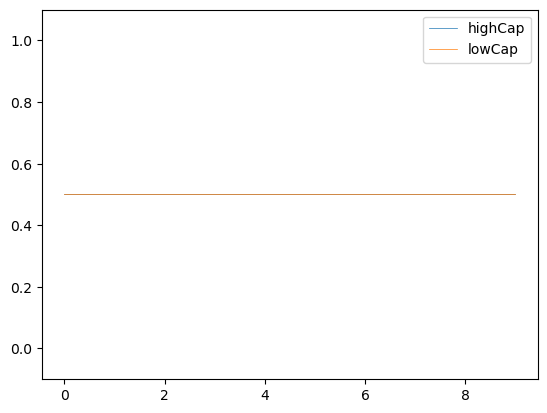

,att
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


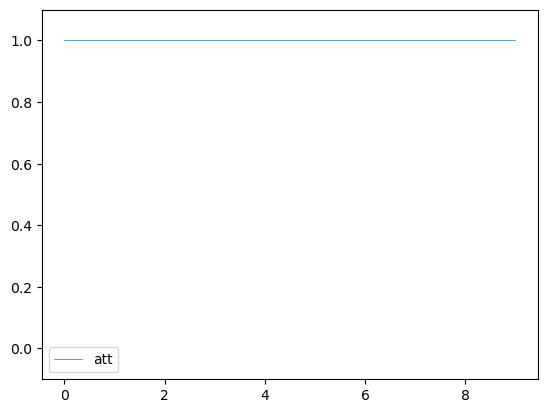

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for state:


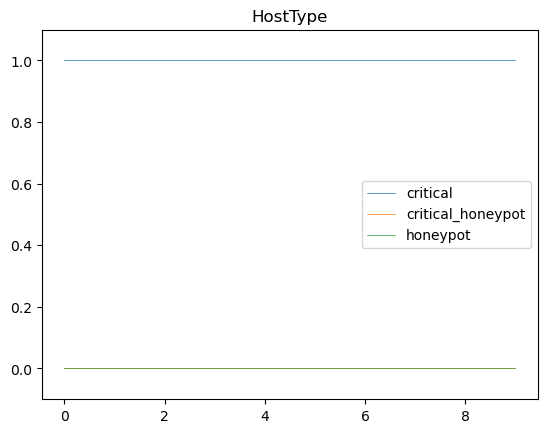

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


,critical,critical_honeypot,honeypot
0,0.5,0.0,0.5
1,0.5,0.0,0.5
2,0.5,0.0,0.5
3,0.5,0.0,0.5
4,0.5,0.0,0.5
5,0.5,0.0,0.5
6,0.5,0.0,0.5
7,0.5,0.0,0.5
8,0.5,0.0,0.5
9,0.5,0.0,0.5


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_i


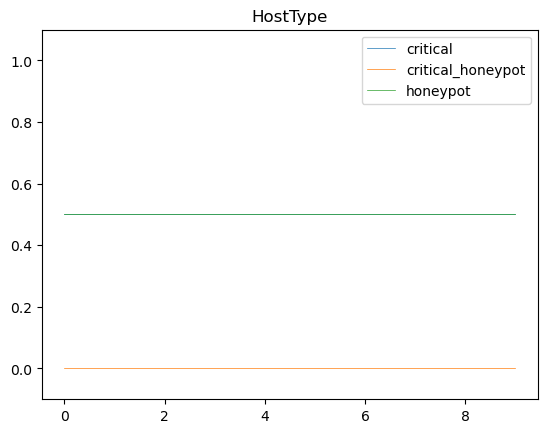

Showing ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


,critical,critical_honeypot,honeypot
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
5,1.0,0.0,0.0
6,1.0,0.0,0.0
7,1.0,0.0,0.0
8,1.0,0.0,0.0
9,1.0,0.0,0.0


Plotting ('HostType', ['critical', 'critical_honeypot', 'honeypot']) for agent_j


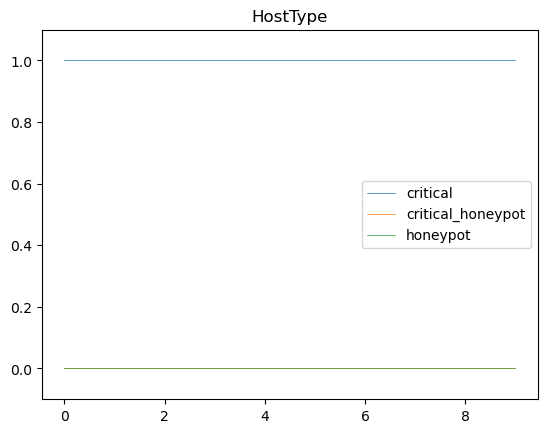

Showing ('HostHasData', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for state:


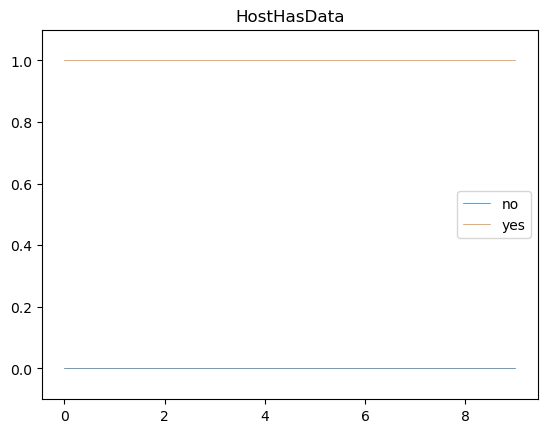

Showing ('HostHasData', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('HostHasData', ['no', 'yes']) for agent_i


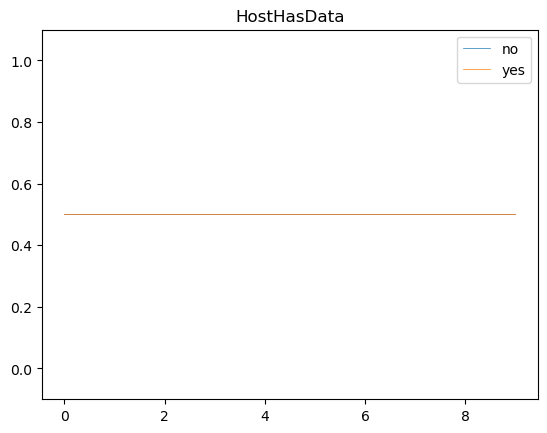

Showing ('HostHasData', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('HostHasData', ['no', 'yes']) for agent_j


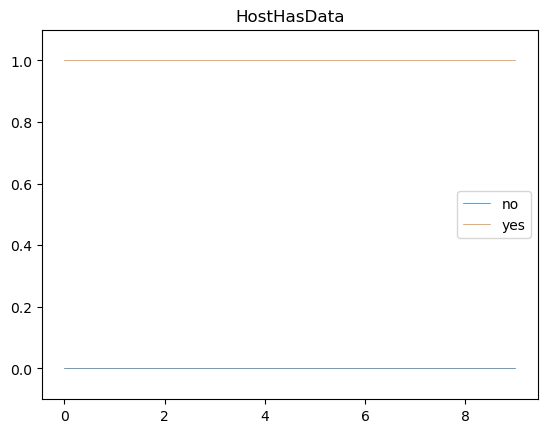

Showing ('DataPrivs', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for state:


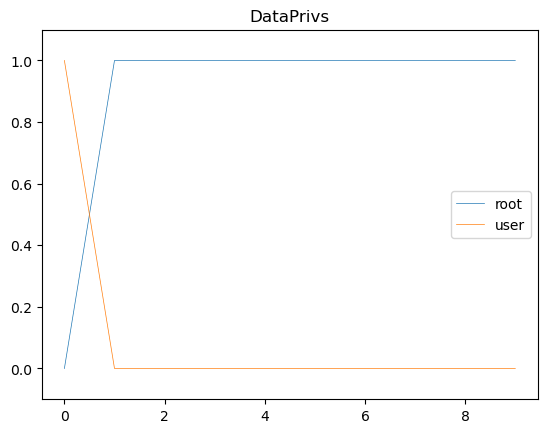

Showing ('DataPrivs', ['root', 'user']) for agent_i


,root,user
0,0.500,0.500
1,0.625,0.375
2,0.625,0.375
3,0.625,0.375
4,0.625,0.375
5,0.625,0.375
6,0.625,0.375
7,0.625,0.375
8,0.625,0.375
9,0.625,0.375


Plotting ('DataPrivs', ['root', 'user']) for agent_i


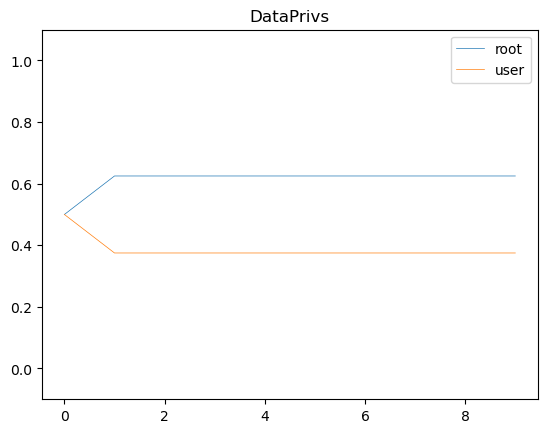

Showing ('DataPrivs', ['root', 'user']) for agent_j


,root,user
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataPrivs', ['root', 'user']) for agent_j


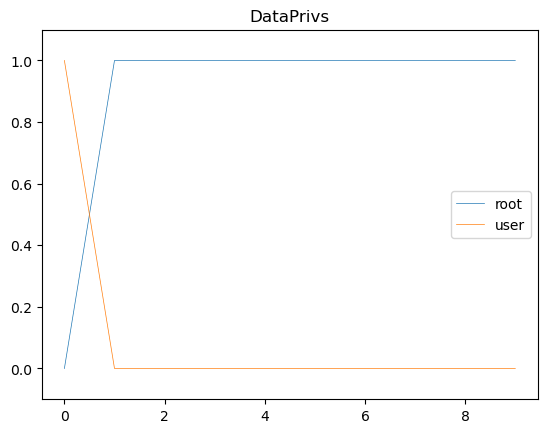

Showing ('EscAccounts', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for state:


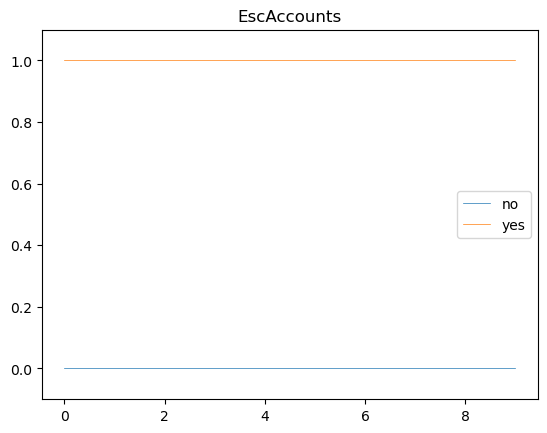

Showing ('EscAccounts', ['no', 'yes']) for agent_i


,no,yes
0,0.5,0.5
1,0.5,0.5
2,0.5,0.5
3,0.5,0.5
4,0.5,0.5
5,0.5,0.5
6,0.5,0.5
7,0.5,0.5
8,0.5,0.5
9,0.5,0.5


Plotting ('EscAccounts', ['no', 'yes']) for agent_i


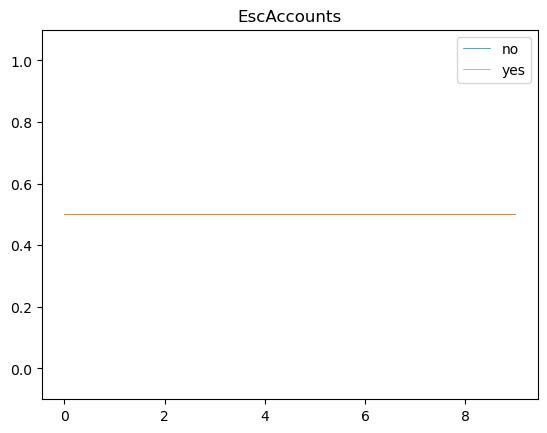

Showing ('EscAccounts', ['no', 'yes']) for agent_j


,no,yes
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('EscAccounts', ['no', 'yes']) for agent_j


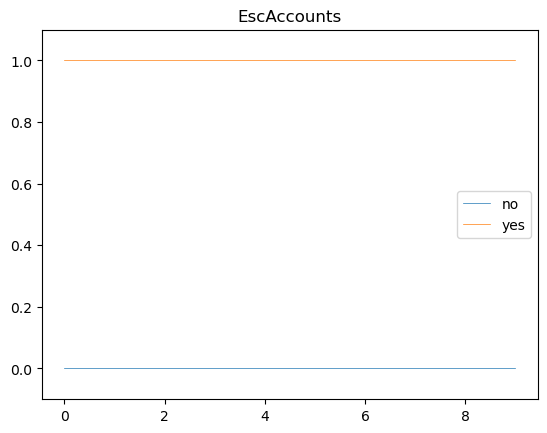

Showing ('AccFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for state:


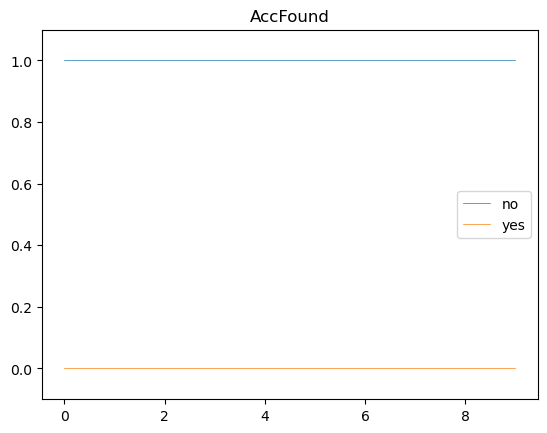

Showing ('AccFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AccFound', ['no', 'yes']) for agent_i


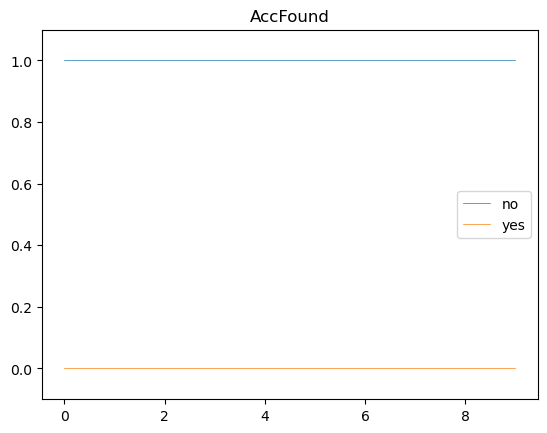

Showing ('AccFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,0.924498,0.075502
4,0.987202,0.012798
5,0.991518,0.008482
6,0.991773,0.008227
7,0.991775,0.008225
8,0.991775,0.008225
9,0.991775,0.008225


Plotting ('AccFound', ['no', 'yes']) for agent_j


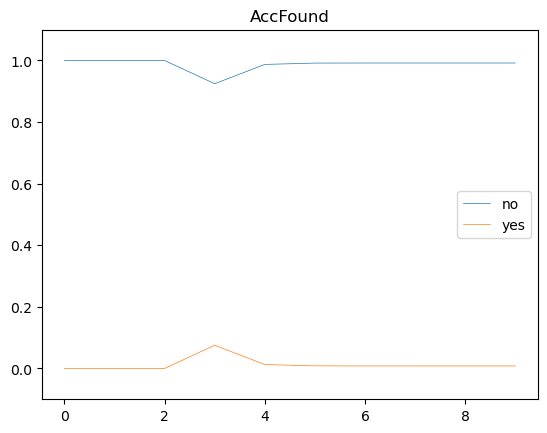

Showing ('DataFound', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for state:


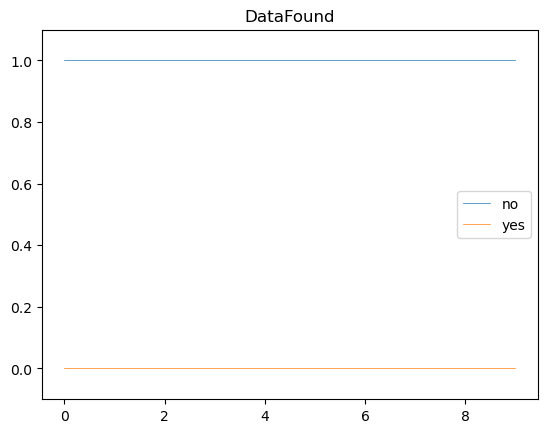

Showing ('DataFound', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataFound', ['no', 'yes']) for agent_i


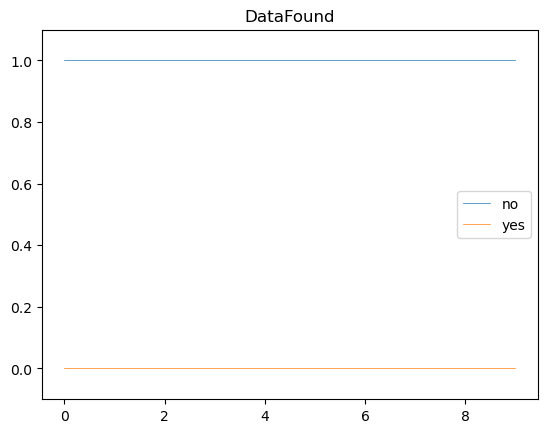

Showing ('DataFound', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,0.200000,0.800000
2,0.200000,0.800000
3,0.267504,0.732496
4,0.275928,0.724072
5,0.276411,0.723589
6,0.276470,0.723530
7,0.276471,0.723529
8,0.276471,0.723529
9,0.276471,0.723529


Plotting ('DataFound', ['no', 'yes']) for agent_j


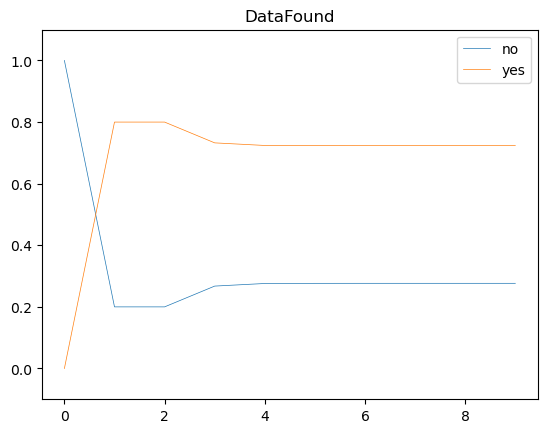

Showing ('AccessLevel', ['root', 'user']) for state:


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for state:


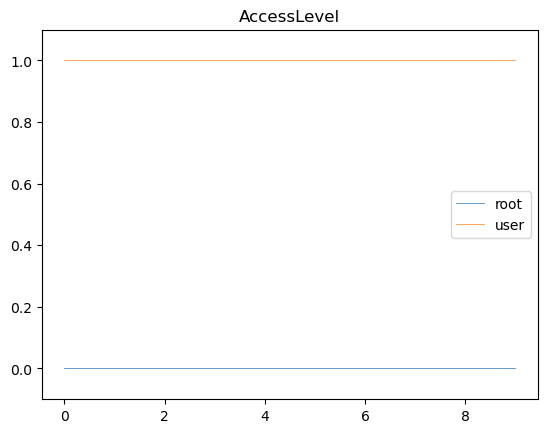

Showing ('AccessLevel', ['root', 'user']) for agent_i


,root,user
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0
5,0.0,1.0
6,0.0,1.0
7,0.0,1.0
8,0.0,1.0
9,0.0,1.0


Plotting ('AccessLevel', ['root', 'user']) for agent_i


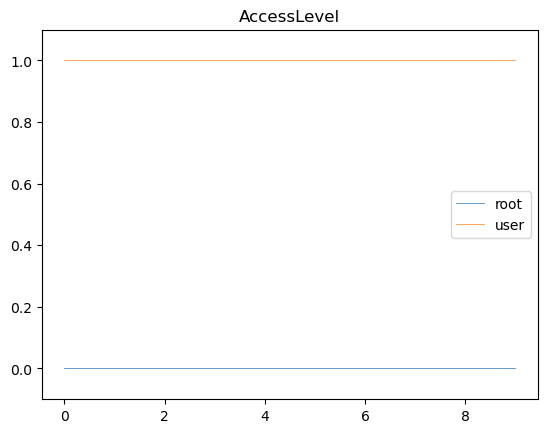

Showing ('AccessLevel', ['root', 'user']) for agent_j


,root,user
0,0.000000,1.000000
1,0.000000,1.000000
2,0.000000,1.000000
3,0.000000,1.000000
4,0.004308,0.995691
5,0.000273,0.999727
6,0.000016,0.999984
7,0.000013,0.999987
8,0.000013,0.999987
9,0.000013,0.999987


Plotting ('AccessLevel', ['root', 'user']) for agent_j


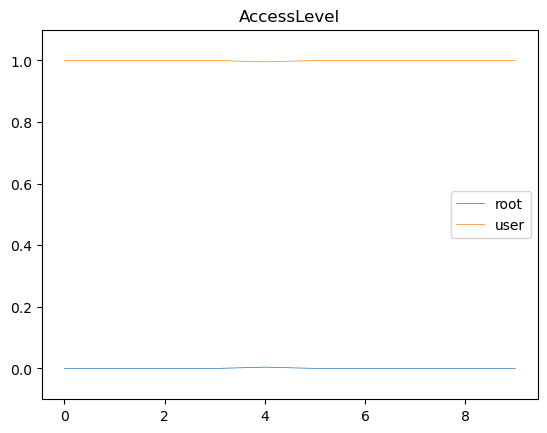

Showing ('AttActive', ['no', 'yes']) for state:


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for state:


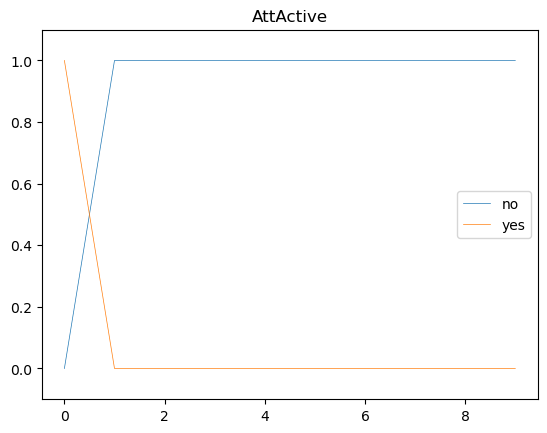

Showing ('AttActive', ['no', 'yes']) for agent_i


,no,yes
0,0.0,1.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('AttActive', ['no', 'yes']) for agent_i


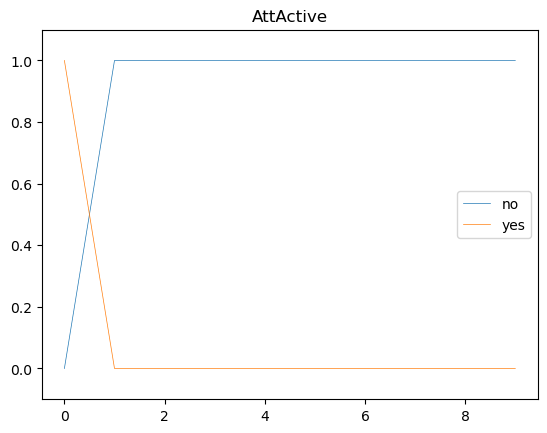

Showing ('AttActive', ['no', 'yes']) for agent_j


,no,yes
0,0.000000,1.000000e+00
1,0.000000,1.000000e+00
2,0.078000,9.219999e-01
3,0.895734,1.042661e-01
4,0.995133,4.866995e-03
5,0.999726,2.737354e-04
6,0.999984,1.607571e-05
7,1.000000,1.673391e-07
8,1.000000,8.607617e-10
9,1.000000,4.404437e-11


Plotting ('AttActive', ['no', 'yes']) for agent_j


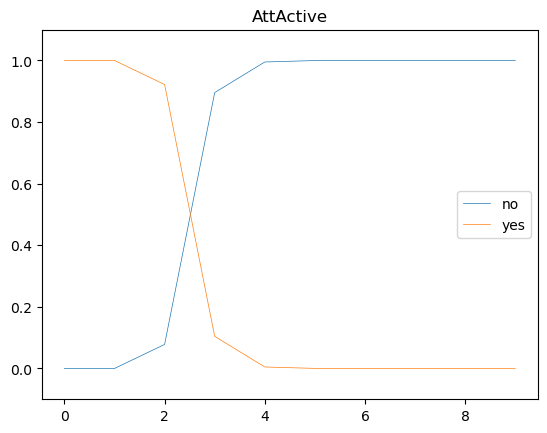

Showing ('DataInjected', ['no', 'yes']) for state:


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for state:


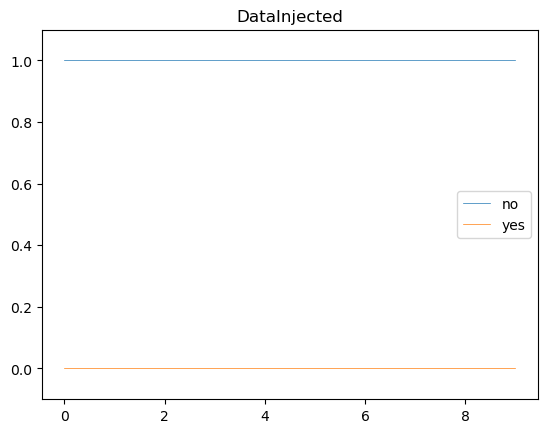

Showing ('DataInjected', ['no', 'yes']) for agent_i


,no,yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,1.0,0.0
9,1.0,0.0


Plotting ('DataInjected', ['no', 'yes']) for agent_i


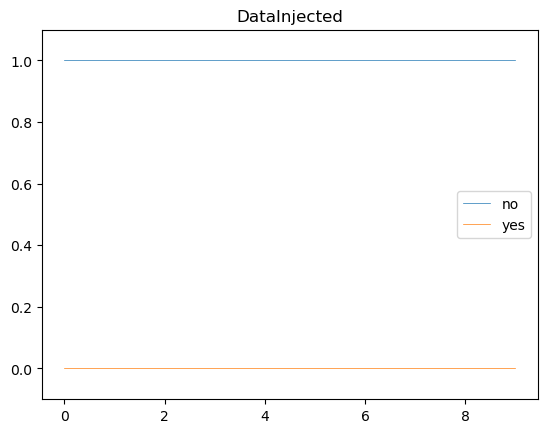

Showing ('DataInjected', ['no', 'yes']) for agent_j


,no,yes
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
5,1.000000,0.000000
6,0.999987,0.000013
7,0.999987,0.000013
8,0.999987,0.000013
9,0.999987,0.000013


Plotting ('DataInjected', ['no', 'yes']) for agent_j


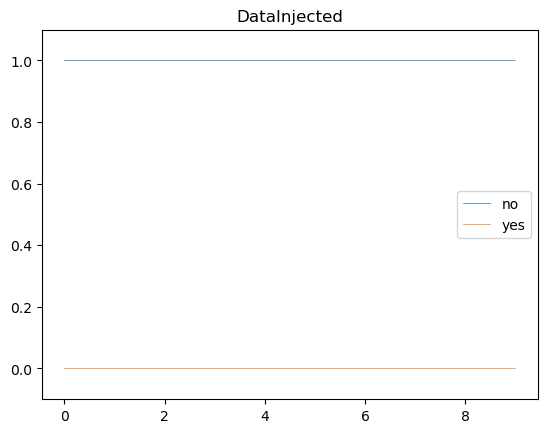

=============== End interaction trace


In [9]:
from IPython.display import display, HTML
from functools import reduce

for trace in data[:5]:
    actions = summarize_interaction.pull_actions(trace)
    display(actions)
    
    try:
        frame_beliefs = summarize_interaction.pull_frame_beliefs(trace)
        
        i_PAj = summarize_interaction.pull_from_trace(trace, lambda x: x, "i_P(Aj)")
        i_PAj = list(reduce(lambda a, b: a + b, map(lambda x: list(x.values()), i_PAj)))
        i_PAj = pandas.DataFrame.from_dict(i_PAj)
        print("Agent i's P(Aj)")
        display(i_PAj)

        j_PAj = summarize_interaction.pull_from_trace(trace, lambda x: x, "j_P(Aj)")
        j_PAj = list(reduce(lambda a, b: a + b, map(lambda x: list(x.values()), j_PAj)))
        j_PAj = pandas.DataFrame.from_dict(j_PAj)
        print("Agent j's P(Aj)")
        display(j_PAj)

        for _b_theta in frame_beliefs:
            display(_b_theta)
            _b_theta.plot(linewidth=0.5)
            plotter.ylim(-0.1, 1.1)
            plotter.show()

        for k in keys:
            beliefs = summarize_interaction.show_belief(trace, k)

            for _b in beliefs.keys():
                print(f"Showing {k} for {_b}")
                display(beliefs[_b])

                print(f"Plotting {k} for {_b}")
                beliefs[_b].plot(legend=True, title=k[0], linewidth=0.5)
                plotter.ylim(-0.1, 1.1)
                plotter.show()

        print("=============== End interaction trace")
    except Exception as e:
        print(e)